GCN

In [7]:
import os
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import json
import numpy as np
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utility function to parse and assign node types
def assign_node_type(node):
    node = node.strip()
    if 'if' in node:
        return 'condition'
    elif 'for' in node or 'while' in node:
        return 'loop'
    elif 'System.out.println' in node:
        return 'output'
    elif node.startswith('//') or node == '' or 'LogFrame' in node:
        return 'meaningless'
    return 'statement'

def assign_edge_type(edge):
    return 'control' if any(keyword in edge[0] for keyword in ['if', 'for', 'while']) else 'data'

# Function to generate PDG from code
def generate_pdg(code):
    G = nx.DiGraph()
    lines = code.splitlines()
    for i, line in enumerate(lines):
        line = line.strip()
        if not line:
            continue
        node_type = assign_node_type(line)
        if node_type != 'meaningless':
            G.add_node(i, label=line, type=node_type)
            if i > 0:
                prev_line = lines[i-1].strip()
                prev_node_type = assign_node_type(prev_line)
                if prev_node_type != 'meaningless':
                    G.add_edge(i-1, i, type=assign_edge_type((prev_line, line)))

    isolated_nodes = [node for node, degree in G.degree if degree == 0]
    G.remove_nodes_from(isolated_nodes)
    mapping = {node: idx for idx, node in enumerate(G.nodes())}
    return nx.relabel_nodes(G, mapping) if G.number_of_nodes() > 0 else None

# Convert NetworkX graph to PyTorch Geometric Data object
def convert_nx_to_torch_data(G):
    node_features = torch.tensor(
        [[int(node_data['type'] == t) for t in ['condition', 'loop', 'output', 'statement']] for _, node_data in G.nodes(data=True)],
        dtype=torch.float
    )
    edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    return Data(x=node_features, edge_index=edge_index)

# Function to load PDG pairs from a dataset
def create_pdg_pairs(data_file, jsonl_file):
    with open(jsonl_file, 'r') as f:
        url_to_code = {entry['idx']: entry['func'] for entry in (json.loads(line.strip()) for line in f)}

    pdg_pairs, true_labels = [], []
    with open(data_file, 'r') as f:
        for line in tqdm(f, desc="Creating PDG pairs"):
            url1, url2, label = line.strip().split('\t')
            if url1 not in url_to_code or url2 not in url_to_code:
                continue

            pdg1, pdg2 = generate_pdg(url_to_code[url1]), generate_pdg(url_to_code[url2])
            if pdg1 is None or pdg2 is None:
                continue

            pdg_pairs.append((convert_nx_to_torch_data(pdg1), convert_nx_to_torch_data(pdg2)))
            true_labels.append(int(label) if label in {'1', '2', '3'} else 0)

    return pdg_pairs, true_labels

# GNN definition
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.3):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        return x

# Graph matcher model
class GraphMatcher(nn.Module):
    def __init__(self, gnn, gembd_vec_dim=128):
        super(GraphMatcher, self).__init__()
        self.gnn = gnn
        self.mlp = nn.Sequential(
            nn.Linear(gnn.conv2.out_channels * 2, gembd_vec_dim),
            nn.ReLU(),
            nn.Linear(gembd_vec_dim, gembd_vec_dim),
            nn.ReLU(),
            nn.Linear(gembd_vec_dim, gembd_vec_dim // 2)
        )

    def forward(self, data1, data2):
        h1 = self.gnn(data1.x, data1.edge_index)
        h2 = self.gnn(data2.x, data2.edge_index)

        h1_pool = global_mean_pool(h1, data1.batch if hasattr(data1, 'batch') else torch.zeros(h1.size(0)).long().to(device))
        h2_pool = global_mean_pool(h2, data2.batch if hasattr(data2, 'batch') else torch.zeros(h2.size(0)).long().to(device))

        h_combined = torch.cat((h1_pool, h2_pool), dim=1)
        return self.mlp(h_combined)

# Full clone detection model
class CloneDetector(nn.Module):
    def __init__(self, gnn, gembd_vec_dim=128):
        super(CloneDetector, self).__init__()
        self.graph_matcher = GraphMatcher(gnn, gembd_vec_dim)
        self.classifier = nn.Sequential(
            nn.Linear(gembd_vec_dim // 2, gembd_vec_dim // 4),
            nn.ReLU(),
            nn.Linear(gembd_vec_dim // 4, 4)
        )

    def forward(self, data1, data2):
        out = self.graph_matcher(data1, data2)
        logits = self.classifier(out)
        probabilities = F.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        return logits, probabilities, predicted_class

# Save checkpoint function
def save_checkpoint(model, optimizer, epoch, f1_score, accuracy, precision, recall, metrics, output_dir):
    checkpoint_path = os.path.join(output_dir, f"model_epoch_{epoch}_f1_{f1_score:.4f}.pth")
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'metrics': {
            'best_f1': f1_score,
            'best_accuracy': accuracy,
            'best_precision': precision,
            'best_recall': recall,
            'per_type_metrics': metrics  
        }
    }, checkpoint_path)
    
    print(f"Checkpoint saved to {checkpoint_path}")
# Training function
def train(model, train_loader, valid_loader, epochs=20, output_dir="checkpoints"):
    optimizer = Adam(model.parameters(), lr=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10, verbose=True)
    criterion = nn.CrossEntropyLoss()
    best_f1 = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            graph_pair, labels = batch
            data1, data2 = graph_pair
            optimizer.zero_grad()

            logits, _, _ = model(data1.to(device), data2.to(device))
            loss = criterion(logits, labels.to(device))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        val_loss, val_metrics = evaluate(model, valid_loader)
        val_f1 = val_metrics['overall']['f1']
        val_accuracy = val_metrics['overall']['accuracy']
        val_precision = val_metrics['overall']['precision']
        val_recall = val_metrics['overall']['recall']
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')
        
        scheduler.step(val_f1)
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            save_checkpoint(model, optimizer, epoch, best_f1, val_accuracy, 
                val_precision, val_recall, val_metrics, output_dir)

# Evaluation function
def evaluate(model, data_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            graph_pair, labels = batch
            data1, data2 = graph_pair
            logits, _, preds = model(data1.to(device), data2.to(device))
            loss = criterion(logits, labels.to(device))
            total_loss += loss.item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds, all_labels = np.array(all_preds), np.array(all_labels)

    metrics = {'overall': {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, average='weighted', zero_division=0),
        'recall': recall_score(all_labels, all_preds, average='weighted', zero_division=0),
        'f1': f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    }}

    for clone_type in range(4):
        type_preds, type_labels = (all_preds == clone_type), (all_labels == clone_type)
        metrics[f'Type-{clone_type+1}'] = {
            'accuracy': accuracy_score(type_labels, type_preds),
            'precision': precision_score(type_labels, type_preds, zero_division=0),
            'recall': recall_score(type_labels, type_preds, zero_division=0),
            'f1': f1_score(type_labels, type_preds, zero_division=0)
        }

    return total_loss / len(data_loader), metrics

# Main execution logic
input_dim = 4
hidden_dim = 64
output_dim = 128
dropout_rate = 0.3
gnn = GNN(input_dim, hidden_dim, output_dim, dropout_rate)
model = CloneDetector(gnn).to(device)

train_file, valid_file = 'test_set/train_5000.txt', 'test_set/train_5000.txt'
jsonl_file = 'test_set/data.jsonl'

train_pdg_pairs, train_labels = create_pdg_pairs(train_file, jsonl_file)
valid_pdg_pairs, valid_labels = create_pdg_pairs(valid_file, jsonl_file)

train_loader = DataLoader(list(zip(train_pdg_pairs, train_labels)), batch_size=64, shuffle=True)
valid_loader = DataLoader(list(zip(valid_pdg_pairs, valid_labels)), batch_size=64)

output_dir = "Ketquacho_DoAn/GCN/5000_sample"
os.makedirs(output_dir, exist_ok=True)

train(model, train_loader, valid_loader, epochs=100, output_dir=output_dir)


Creating PDG pairs: 3000it [00:03, 998.20it/s] 
Creating PDG pairs: 3000it [00:03, 950.07it/s] 
c:\Users\PC\Desktop\pythonProject1\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Evaluating: 100%|██████████| 31/31 [00:01<00:00, 27.88it/s]


Epoch 1/100, Train Loss: 1.2851, Val Loss: 1.1376, Val F1: 0.4349
Checkpoint saved to Ketquacho_DoAn/GCN/5000_sample\model_epoch_0_f1_0.4349.pth


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 39.36it/s]


Epoch 2/100, Train Loss: 1.0367, Val Loss: 0.9683, Val F1: 0.4423
Checkpoint saved to Ketquacho_DoAn/GCN/5000_sample\model_epoch_1_f1_0.4423.pth


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 36.27it/s]


Epoch 3/100, Train Loss: 0.8725, Val Loss: 0.8534, Val F1: 0.5498
Checkpoint saved to Ketquacho_DoAn/GCN/5000_sample\model_epoch_2_f1_0.5498.pth


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 35.00it/s]


Epoch 4/100, Train Loss: 0.7707, Val Loss: 0.7029, Val F1: 0.6295
Checkpoint saved to Ketquacho_DoAn/GCN/5000_sample\model_epoch_3_f1_0.6295.pth


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 42.27it/s]


Epoch 5/100, Train Loss: 0.7560, Val Loss: 0.7305, Val F1: 0.5814


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 46.37it/s]


Epoch 6/100, Train Loss: 0.7850, Val Loss: 0.7754, Val F1: 0.5256


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 41.80it/s]


Epoch 7/100, Train Loss: 0.7693, Val Loss: 0.7201, Val F1: 0.5903


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 29.76it/s]


Epoch 8/100, Train Loss: 0.7287, Val Loss: 0.7095, Val F1: 0.6107


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 50.56it/s]


Epoch 9/100, Train Loss: 0.7455, Val Loss: 0.8031, Val F1: 0.6817
Checkpoint saved to Ketquacho_DoAn/GCN/5000_sample\model_epoch_8_f1_0.6817.pth


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 39.94it/s]


Epoch 10/100, Train Loss: 0.7438, Val Loss: 0.7117, Val F1: 0.6222


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 47.68it/s]


Epoch 11/100, Train Loss: 0.7198, Val Loss: 0.6903, Val F1: 0.6770


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 57.13it/s]


Epoch 12/100, Train Loss: 0.6828, Val Loss: 0.6402, Val F1: 0.6170


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 46.52it/s]


Epoch 13/100, Train Loss: 0.6363, Val Loss: 0.6629, Val F1: 0.6618


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 34.46it/s]


Epoch 14/100, Train Loss: 0.6405, Val Loss: 0.6014, Val F1: 0.6227


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 57.49it/s]


Epoch 15/100, Train Loss: 0.6162, Val Loss: 0.5954, Val F1: 0.6490


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 62.19it/s]


Epoch 16/100, Train Loss: 0.6054, Val Loss: 0.5528, Val F1: 0.7152
Checkpoint saved to Ketquacho_DoAn/GCN/5000_sample\model_epoch_15_f1_0.7152.pth


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 64.34it/s]


Epoch 17/100, Train Loss: 0.5942, Val Loss: 0.5496, Val F1: 0.6625


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 62.34it/s]


Epoch 18/100, Train Loss: 0.5970, Val Loss: 0.6033, Val F1: 0.7021


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 56.71it/s]


Epoch 19/100, Train Loss: 0.5853, Val Loss: 0.5425, Val F1: 0.7265
Checkpoint saved to Ketquacho_DoAn/GCN/5000_sample\model_epoch_18_f1_0.7265.pth


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 45.25it/s]


Epoch 20/100, Train Loss: 0.5945, Val Loss: 0.5598, Val F1: 0.7068


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 59.21it/s]


Epoch 21/100, Train Loss: 0.5780, Val Loss: 0.5462, Val F1: 0.7218


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 49.51it/s]


Epoch 22/100, Train Loss: 0.5714, Val Loss: 0.5514, Val F1: 0.6904


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 55.71it/s]


Epoch 23/100, Train Loss: 0.5596, Val Loss: 0.7277, Val F1: 0.6525


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 62.00it/s]


Epoch 24/100, Train Loss: 0.5913, Val Loss: 0.5515, Val F1: 0.6285


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 54.14it/s]


Epoch 25/100, Train Loss: 0.5669, Val Loss: 0.5560, Val F1: 0.7289
Checkpoint saved to Ketquacho_DoAn/GCN/5000_sample\model_epoch_24_f1_0.7289.pth


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 60.74it/s]


Epoch 26/100, Train Loss: 0.5552, Val Loss: 0.5307, Val F1: 0.7296
Checkpoint saved to Ketquacho_DoAn/GCN/5000_sample\model_epoch_25_f1_0.7296.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 29.87it/s]


Epoch 27/100, Train Loss: 0.5556, Val Loss: 0.5160, Val F1: 0.7357
Checkpoint saved to Ketquacho_DoAn/GCN/5000_sample\model_epoch_26_f1_0.7357.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 30.59it/s]


Epoch 28/100, Train Loss: 0.5471, Val Loss: 0.5235, Val F1: 0.6982


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 34.52it/s]


Epoch 29/100, Train Loss: 0.5614, Val Loss: 0.5130, Val F1: 0.7361
Checkpoint saved to Ketquacho_DoAn/GCN/5000_sample\model_epoch_28_f1_0.7361.pth


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 41.64it/s]


Epoch 30/100, Train Loss: 0.5648, Val Loss: 0.5151, Val F1: 0.7378
Checkpoint saved to Ketquacho_DoAn/GCN/5000_sample\model_epoch_29_f1_0.7378.pth


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 50.25it/s]


Epoch 31/100, Train Loss: 0.5620, Val Loss: 0.5244, Val F1: 0.7297


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 45.22it/s]


Epoch 32/100, Train Loss: 0.5475, Val Loss: 0.5597, Val F1: 0.6995


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 43.98it/s]


Epoch 33/100, Train Loss: 0.5497, Val Loss: 0.5386, Val F1: 0.7373


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 50.45it/s]


Epoch 34/100, Train Loss: 0.5543, Val Loss: 0.5211, Val F1: 0.7266


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 56.48it/s]


Epoch 35/100, Train Loss: 0.5360, Val Loss: 0.5171, Val F1: 0.7510
Checkpoint saved to Ketquacho_DoAn/GCN/5000_sample\model_epoch_34_f1_0.7510.pth


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 54.67it/s]


Epoch 36/100, Train Loss: 0.5430, Val Loss: 0.5254, Val F1: 0.7263


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 51.99it/s]


Epoch 37/100, Train Loss: 0.5839, Val Loss: 0.5505, Val F1: 0.6409


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 53.11it/s]


Epoch 38/100, Train Loss: 0.5846, Val Loss: 0.5601, Val F1: 0.7079


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 58.06it/s]


Epoch 39/100, Train Loss: 0.5749, Val Loss: 0.5247, Val F1: 0.7217


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 55.11it/s]


Epoch 40/100, Train Loss: 0.5584, Val Loss: 0.5391, Val F1: 0.6861


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 60.89it/s]


Epoch 41/100, Train Loss: 0.5415, Val Loss: 0.5150, Val F1: 0.7333


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 61.44it/s]


Epoch 42/100, Train Loss: 0.5494, Val Loss: 0.5133, Val F1: 0.7397


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 61.44it/s]


Epoch 43/100, Train Loss: 0.5641, Val Loss: 0.5150, Val F1: 0.7417


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 57.21it/s]


Epoch 44/100, Train Loss: 0.5273, Val Loss: 0.5289, Val F1: 0.7280


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 65.27it/s]


Epoch 45/100, Train Loss: 0.5344, Val Loss: 0.5178, Val F1: 0.7325


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 49.40it/s]


Epoch 46/100, Train Loss: 0.5326, Val Loss: 0.5060, Val F1: 0.7580
Checkpoint saved to Ketquacho_DoAn/GCN/5000_sample\model_epoch_45_f1_0.7580.pth


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 59.32it/s]


Epoch 47/100, Train Loss: 0.5369, Val Loss: 0.5141, Val F1: 0.7498


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 63.98it/s]


Epoch 48/100, Train Loss: 0.5345, Val Loss: 0.5036, Val F1: 0.7446


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 40.73it/s]


Epoch 49/100, Train Loss: 0.5359, Val Loss: 0.5040, Val F1: 0.7419


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 29.63it/s]


Epoch 50/100, Train Loss: 0.5502, Val Loss: 0.5201, Val F1: 0.7398


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 41.07it/s]


Epoch 51/100, Train Loss: 0.5474, Val Loss: 0.5228, Val F1: 0.7476


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 44.55it/s]


Epoch 52/100, Train Loss: 0.5265, Val Loss: 0.5052, Val F1: 0.7547


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 52.44it/s]


Epoch 53/100, Train Loss: 0.5231, Val Loss: 0.4968, Val F1: 0.7666
Checkpoint saved to Ketquacho_DoAn/GCN/5000_sample\model_epoch_52_f1_0.7666.pth


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 49.45it/s]


Epoch 54/100, Train Loss: 0.5111, Val Loss: 0.4954, Val F1: 0.7536


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 42.84it/s]


Epoch 55/100, Train Loss: 0.5180, Val Loss: 0.4909, Val F1: 0.7640


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 49.13it/s]


Epoch 56/100, Train Loss: 0.5291, Val Loss: 0.5017, Val F1: 0.7516


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 52.66it/s]


Epoch 57/100, Train Loss: 0.5144, Val Loss: 0.4859, Val F1: 0.7580


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 62.16it/s]


Epoch 58/100, Train Loss: 0.5050, Val Loss: 0.4876, Val F1: 0.7590


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 49.14it/s]


Epoch 59/100, Train Loss: 0.5184, Val Loss: 0.5030, Val F1: 0.7608


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 52.08it/s]


Epoch 60/100, Train Loss: 0.5103, Val Loss: 0.4966, Val F1: 0.7520


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 39.30it/s]


Epoch 61/100, Train Loss: 0.5139, Val Loss: 0.4758, Val F1: 0.7717
Checkpoint saved to Ketquacho_DoAn/GCN/5000_sample\model_epoch_60_f1_0.7717.pth


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 36.54it/s]


Epoch 62/100, Train Loss: 0.5142, Val Loss: 0.4882, Val F1: 0.7702


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 41.74it/s]


Epoch 63/100, Train Loss: 0.5235, Val Loss: 0.4923, Val F1: 0.7534


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 45.85it/s]


Epoch 64/100, Train Loss: 0.5368, Val Loss: 0.5094, Val F1: 0.7435


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 45.82it/s]


Epoch 65/100, Train Loss: 0.5538, Val Loss: 0.5010, Val F1: 0.7671


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 47.36it/s]


Epoch 66/100, Train Loss: 0.5337, Val Loss: 0.4968, Val F1: 0.7561


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 47.81it/s]


Epoch 67/100, Train Loss: 0.5239, Val Loss: 0.5041, Val F1: 0.7559


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 45.01it/s]


Epoch 68/100, Train Loss: 0.5230, Val Loss: 0.4895, Val F1: 0.7699


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 39.47it/s]


Epoch 69/100, Train Loss: 0.5058, Val Loss: 0.4781, Val F1: 0.7779
Checkpoint saved to Ketquacho_DoAn/GCN/5000_sample\model_epoch_68_f1_0.7779.pth


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 46.31it/s]


Epoch 70/100, Train Loss: 0.5020, Val Loss: 0.4821, Val F1: 0.7685


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 26.22it/s]


Epoch 71/100, Train Loss: 0.5104, Val Loss: 0.4746, Val F1: 0.7687


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 43.13it/s]


Epoch 72/100, Train Loss: 0.4927, Val Loss: 0.4685, Val F1: 0.7818
Checkpoint saved to Ketquacho_DoAn/GCN/5000_sample\model_epoch_71_f1_0.7818.pth


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 47.35it/s]


Epoch 73/100, Train Loss: 0.5018, Val Loss: 0.4720, Val F1: 0.7795


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 43.16it/s]


Epoch 74/100, Train Loss: 0.4920, Val Loss: 0.4708, Val F1: 0.7755


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 48.53it/s]


Epoch 75/100, Train Loss: 0.5103, Val Loss: 0.4773, Val F1: 0.7805


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 48.46it/s]


Epoch 76/100, Train Loss: 0.5044, Val Loss: 0.4656, Val F1: 0.7773


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 52.01it/s]


Epoch 77/100, Train Loss: 0.4938, Val Loss: 0.4773, Val F1: 0.7709


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 45.70it/s]


Epoch 78/100, Train Loss: 0.5128, Val Loss: 0.4636, Val F1: 0.7794


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 43.07it/s]


Epoch 79/100, Train Loss: 0.4873, Val Loss: 0.4782, Val F1: 0.7685


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 48.91it/s]


Epoch 80/100, Train Loss: 0.5027, Val Loss: 0.4673, Val F1: 0.7800


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 18.81it/s]


Epoch 81/100, Train Loss: 0.4939, Val Loss: 0.4640, Val F1: 0.7735


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 24.54it/s]


Epoch 82/100, Train Loss: 0.4861, Val Loss: 0.4576, Val F1: 0.7895
Checkpoint saved to Ketquacho_DoAn/GCN/5000_sample\model_epoch_81_f1_0.7895.pth


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 36.90it/s]


Epoch 83/100, Train Loss: 0.4906, Val Loss: 0.4536, Val F1: 0.7859


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 33.27it/s]


Epoch 84/100, Train Loss: 0.4897, Val Loss: 0.4479, Val F1: 0.7879


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 40.19it/s]


Epoch 85/100, Train Loss: 0.5007, Val Loss: 0.5139, Val F1: 0.7651


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 33.75it/s]


Epoch 86/100, Train Loss: 0.5364, Val Loss: 0.4933, Val F1: 0.7691


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 45.71it/s]


Epoch 87/100, Train Loss: 0.5448, Val Loss: 0.4849, Val F1: 0.7593


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 46.22it/s]


Epoch 88/100, Train Loss: 0.5080, Val Loss: 0.4966, Val F1: 0.7619


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 44.54it/s]


Epoch 89/100, Train Loss: 0.4993, Val Loss: 0.4557, Val F1: 0.7890


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 47.42it/s]


Epoch 90/100, Train Loss: 0.4945, Val Loss: 0.4721, Val F1: 0.7822


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 48.55it/s]


Epoch 91/100, Train Loss: 0.4833, Val Loss: 0.4816, Val F1: 0.7882


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 52.45it/s]


Epoch 92/100, Train Loss: 0.4836, Val Loss: 0.4561, Val F1: 0.7965
Checkpoint saved to Ketquacho_DoAn/GCN/5000_sample\model_epoch_91_f1_0.7965.pth


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 49.09it/s]


Epoch 93/100, Train Loss: 0.4778, Val Loss: 0.4484, Val F1: 0.7894


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 46.92it/s]


Epoch 94/100, Train Loss: 0.5005, Val Loss: 0.4712, Val F1: 0.7773


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 49.02it/s]


Epoch 95/100, Train Loss: 0.5021, Val Loss: 0.4660, Val F1: 0.7882


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 32.86it/s]


Epoch 96/100, Train Loss: 0.5042, Val Loss: 0.4701, Val F1: 0.7888


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 50.94it/s]


Epoch 97/100, Train Loss: 0.5230, Val Loss: 0.4955, Val F1: 0.7745


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 37.70it/s]


Epoch 98/100, Train Loss: 0.5697, Val Loss: 0.5222, Val F1: 0.7420


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 40.63it/s]


Epoch 99/100, Train Loss: 0.5286, Val Loss: 0.4888, Val F1: 0.7612


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 45.69it/s]

Epoch 100/100, Train Loss: 0.5245, Val Loss: 0.4789, Val F1: 0.7717


In [3]:
checkpoint = torch.load('Ketquacho_DoAn/GCN/100_sample/model_epoch_0_f1_0.3114.pth')
per_type_metrics = checkpoint['metrics']['per_type_metrics']

# Print overall metrics first
overall_metrics = per_type_metrics['overall']
print("Overall metrics:")
print(f"Accuracy-score: {overall_metrics['accuracy']:.4f}")
print(f"Precision-score: {overall_metrics['precision']:.4f}")
print(f"Recall-score: {overall_metrics['recall']:.4f}")
print(f"F1-score: {overall_metrics['f1']:.4f}")

# Print per-type metrics
for clone_type, metrics in per_type_metrics.items():
    if clone_type != 'overall':  # Skip overall metrics since already printed
        print(f"\n{clone_type}:")
        print(f"Accuracy-score: {metrics['accuracy']:.4f}")
        print(f"Precision-score: {metrics['precision']:.4f}")
        print(f"Recall-score: {metrics['recall']:.4f}")
        print(f"F1-score: {metrics['f1']:.4f}")



Overall metrics:
Accuracy-score: 0.4800
Precision-score: 0.2304
Recall-score: 0.4800
F1-score: 0.3114

Type-1:
Accuracy-score: 1.0000
Precision-score: 0.0000
Recall-score: 0.0000
F1-score: 0.0000

Type-2:
Accuracy-score: 0.8400
Precision-score: 0.0000
Recall-score: 0.0000
F1-score: 0.0000

Type-3:
Accuracy-score: 0.4800
Precision-score: 0.4800
Recall-score: 1.0000
F1-score: 0.6486

Type-4:
Accuracy-score: 0.6400
Precision-score: 0.0000
Recall-score: 0.0000
F1-score: 0.0000


In [5]:
checkpoint = torch.load('Ketquacho_DoAn/GCN/1000_sample/model_epoch_58_f1_0.8849.pth')
per_type_metrics = checkpoint['metrics']['per_type_metrics']

# Print overall metrics first
overall_metrics = per_type_metrics['overall']
print("Overall metrics:")
print(f"Accuracy-score: {overall_metrics['accuracy']:.4f}")
print(f"Precision-score: {overall_metrics['precision']:.4f}")
print(f"Recall-score: {overall_metrics['recall']:.4f}")
print(f"F1-score: {overall_metrics['f1']:.4f}")

# Print per-type metrics
for clone_type, metrics in per_type_metrics.items():
    if clone_type != 'overall':  # Skip overall metrics since already printed
        print(f"\n{clone_type}:")
        print(f"Accuracy-score: {metrics['accuracy']:.4f}")
        print(f"Precision-score: {metrics['precision']:.4f}")
        print(f"Recall-score: {metrics['recall']:.4f}")
        print(f"F1-score: {metrics['f1']:.4f}")



Overall metrics:
Accuracy-score: 0.8861
Precision-score: 0.8862
Recall-score: 0.8861
F1-score: 0.8849

Type-1:
Accuracy-score: 0.9929
Precision-score: 0.0000
Recall-score: 0.0000
F1-score: 0.0000

Type-2:
Accuracy-score: 0.9253
Precision-score: 0.7045
Recall-score: 0.7949
F1-score: 0.7470

Type-3:
Accuracy-score: 0.9004
Precision-score: 0.8794
Recall-score: 0.9185
F1-score: 0.8986

Type-4:
Accuracy-score: 0.9537
Precision-score: 0.9792
Recall-score: 0.8952
F1-score: 0.9353


GIN

In [28]:
import os
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_mean_pool
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import json
import numpy as np
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utility function to parse and assign node types
def assign_node_type(node):
    node = node.strip()
    if 'if' in node:
        return 'condition'
    elif 'for' in node or 'while' in node:
        return 'loop'
    elif 'System.out.println' in node:
        return 'output'
    elif node.startswith('//') or node == '' or 'LogFrame' in node:
        return 'meaningless'
    return 'statement'

def assign_edge_type(edge):
    return 'control' if any(keyword in edge[0] for keyword in ['if', 'for', 'while']) else 'data'

# Function to generate PDG from code
def generate_pdg(code):
    G = nx.DiGraph()
    lines = code.splitlines()
    for i, line in enumerate(lines):
        line = line.strip()
        if not line:
            continue
        node_type = assign_node_type(line)
        if node_type != 'meaningless':
            G.add_node(i, label=line, type=node_type)
            if i > 0:
                prev_line = lines[i-1].strip()
                prev_node_type = assign_node_type(prev_line)
                if prev_node_type != 'meaningless':
                    G.add_edge(i-1, i, type=assign_edge_type((prev_line, line)))

    isolated_nodes = [node for node, degree in G.degree if degree == 0]
    G.remove_nodes_from(isolated_nodes)
    mapping = {node: idx for idx, node in enumerate(G.nodes())}
    return nx.relabel_nodes(G, mapping) if G.number_of_nodes() > 0 else None

# Convert NetworkX graph to PyTorch Geometric Data object
def convert_nx_to_torch_data(G):
    node_features = torch.tensor(
        [[int(node_data['type'] == t) for t in ['condition', 'loop', 'output', 'statement']] for _, node_data in G.nodes(data=True)],
        dtype=torch.float
    )
    edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    return Data(x=node_features, edge_index=edge_index)

# Function to load PDG pairs from a dataset
def create_pdg_pairs(data_file, jsonl_file):
    with open(jsonl_file, 'r') as f:
        url_to_code = {entry['idx']: entry['func'] for entry in (json.loads(line.strip()) for line in f)}

    pdg_pairs, true_labels = [], []
    with open(data_file, 'r') as f:
        for line in tqdm(f, desc="Creating PDG pairs"):
            url1, url2, label = line.strip().split('\t')
            if url1 not in url_to_code or url2 not in url_to_code:
                continue

            pdg1, pdg2 = generate_pdg(url_to_code[url1]), generate_pdg(url_to_code[url2])
            if pdg1 is None or pdg2 is None:
                continue

            pdg_pairs.append((convert_nx_to_torch_data(pdg1), convert_nx_to_torch_data(pdg2)))
            true_labels.append(int(label) if label in {'1', '2', '3'} else 0)

    return pdg_pairs, true_labels

class GINNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3, dropout_rate: float = 0.3):
        super(GINNet, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)

        # Input layer
        self.conv_layers.append(GINConv(nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )))
        self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.conv_layers.append(GINConv(nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            )))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        # Output layer
        self.conv_layers.append(GINConv(nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim)
        )))
        self.batch_norms.append(nn.BatchNorm1d(output_dim))

    def forward(self, x, edge_index):
        for conv, bn in zip(self.conv_layers, self.batch_norms):
            x = conv(x, edge_index)
            x = bn(x)
            x = F.relu(x)
            x = self.dropout(x)  
        return x


# Cập nhật GraphMatcher để sử dụng GINNet
class GraphMatcher(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, gembd_vec_dim=128):
        super(GraphMatcher, self).__init__()
        self.gnn = GINNet(input_dim, hidden_dim, output_dim)
        self.mlp = nn.Sequential(
            nn.Linear(output_dim * 2, gembd_vec_dim),
            nn.ReLU(),
            nn.Linear(gembd_vec_dim, gembd_vec_dim),
            nn.ReLU(),
            nn.Linear(gembd_vec_dim, gembd_vec_dim // 2)
        )

    def forward(self, data1, data2):
        h1 = self.gnn(data1.x, data1.edge_index)
        h2 = self.gnn(data2.x, data2.edge_index)

        h1_pool = global_mean_pool(h1, data1.batch if hasattr(data1, 'batch') else torch.zeros(h1.size(0)).long().to(device))
        h2_pool = global_mean_pool(h2, data2.batch if hasattr(data2, 'batch') else torch.zeros(h2.size(0)).long().to(device))

        h_combined = torch.cat((h1_pool, h2_pool), dim=1)
        return self.mlp(h_combined)

# Cập nhật CloneDetector để sử dụng GraphMatcher mới
class CloneDetector(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, gembd_vec_dim=128):
        super(CloneDetector, self).__init__()
        self.graph_matcher = GraphMatcher(input_dim, hidden_dim, output_dim, gembd_vec_dim)
        self.classifier = nn.Sequential(
            nn.Linear(gembd_vec_dim // 2, gembd_vec_dim // 4),
            nn.ReLU(),
            nn.Linear(gembd_vec_dim // 4, 4)
        )

    def forward(self, data1, data2):
        out = self.graph_matcher(data1, data2)
        logits = self.classifier(out)
        probabilities = F.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        return logits, probabilities, predicted_class

# Save checkpoint function
def save_checkpoint(model, optimizer, epoch, f1_score, accuracy, precision, recall, metrics, output_dir):
    checkpoint_path = os.path.join(output_dir, f"model_epoch_{epoch}_f1_{f1_score:.4f}.pth")
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'metrics': {
            'best_f1': f1_score,
            'best_accuracy': accuracy,
            'best_precision': precision,
            'best_recall': recall,
            'per_type_metrics': metrics  
        }
    }, checkpoint_path)
    
    print(f"Checkpoint saved to {checkpoint_path}")
# Training function
def train(model, train_loader, valid_loader, epochs=20, output_dir="checkpoints"):
    optimizer = Adam(model.parameters(), lr=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10, verbose=True)
    criterion = nn.CrossEntropyLoss()
    best_f1 = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            graph_pair, labels = batch
            data1, data2 = graph_pair
            optimizer.zero_grad()

            logits, _, _ = model(data1.to(device), data2.to(device))
            loss = criterion(logits, labels.to(device))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        val_loss, val_metrics = evaluate(model, valid_loader)
        val_f1 = val_metrics['overall']['f1']
        val_accuracy = val_metrics['overall']['accuracy']
        val_precision = val_metrics['overall']['precision']
        val_recall = val_metrics['overall']['recall']
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')
        
        scheduler.step(val_f1)
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            save_checkpoint(model, optimizer, epoch, best_f1, val_accuracy, 
                val_precision, val_recall, val_metrics, output_dir)

# Evaluation function
def evaluate(model, data_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            graph_pair, labels = batch
            data1, data2 = graph_pair
            logits, _, preds = model(data1.to(device), data2.to(device))
            loss = criterion(logits, labels.to(device))
            total_loss += loss.item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds, all_labels = np.array(all_preds), np.array(all_labels)

    metrics = {'overall': {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, average='weighted', zero_division=0),
        'recall': recall_score(all_labels, all_preds, average='weighted', zero_division=0),
        'f1': f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    }}

    for clone_type in range(4):
        type_preds, type_labels = (all_preds == clone_type), (all_labels == clone_type)
        metrics[f'Type-{clone_type+1}'] = {
            'accuracy': accuracy_score(type_labels, type_preds),
            'precision': precision_score(type_labels, type_preds, zero_division=0),
            'recall': recall_score(type_labels, type_preds, zero_division=0),
            'f1': f1_score(type_labels, type_preds, zero_division=0)
        }

    return total_loss / len(data_loader), metrics

# Main execution logic
input_dim = 4
hidden_dim = 64
output_dim = 128
num_layers = 3
dropout_rate: float = 0.3
gnn = GINNet(input_dim, hidden_dim, output_dim, num_layers, dropout_rate)
model = CloneDetector(input_dim, hidden_dim, output_dim).to(device)

train_file, valid_file = 'test_set/train_100.txt', 'test_set/train_100.txt'
jsonl_file = 'test_set/data.jsonl'

train_pdg_pairs, train_labels = create_pdg_pairs(train_file, jsonl_file)
valid_pdg_pairs, valid_labels = create_pdg_pairs(valid_file, jsonl_file)

train_loader = DataLoader(list(zip(train_pdg_pairs, train_labels)), batch_size=64, shuffle=True)
valid_loader = DataLoader(list(zip(valid_pdg_pairs, valid_labels)), batch_size=64)

output_dir = "Ketquacho_DoAn/GIN/100_sample"
os.makedirs(output_dir, exist_ok=True)

train(model, train_loader, valid_loader, epochs=100, output_dir=output_dir)

Creating PDG pairs: 60it [00:00, 2188.41it/s]
Creating PDG pairs: 60it [00:00, 1501.34it/s]
c:\Users\PC\Desktop\pythonProject1\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Evaluating: 100%|██████████| 1/1 [00:00<00:00, 66.25it/s]


Epoch 1/100, Train Loss: 1.3902, Val Loss: 1.3151, Val F1: 0.1906
Checkpoint saved to Ketquacho_DoAn/GIN/100_sample\model_epoch_0_f1_0.1906.pth


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 87.60it/s]


Epoch 2/100, Train Loss: 1.2031, Val Loss: 1.1830, Val F1: 0.1906


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.47it/s]


Epoch 3/100, Train Loss: 1.3672, Val Loss: 1.1756, Val F1: 0.3114
Checkpoint saved to Ketquacho_DoAn/GIN/100_sample\model_epoch_2_f1_0.3114.pth


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 72.01it/s]


Epoch 4/100, Train Loss: 1.5079, Val Loss: 1.2320, Val F1: 0.3114


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


Epoch 5/100, Train Loss: 1.0840, Val Loss: 1.2488, Val F1: 0.3114


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 70.07it/s]


Epoch 6/100, Train Loss: 1.1825, Val Loss: 1.2470, Val F1: 0.3114


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 31.07it/s]


Epoch 7/100, Train Loss: 1.2046, Val Loss: 1.2264, Val F1: 0.3114


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 75.11it/s]


Epoch 8/100, Train Loss: 1.1875, Val Loss: 1.1873, Val F1: 0.3114


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 70.05it/s]


Epoch 9/100, Train Loss: 1.1311, Val Loss: 1.1226, Val F1: 0.3114


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 52.39it/s]


Epoch 10/100, Train Loss: 1.0646, Val Loss: 1.0441, Val F1: 0.3114


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 101.66it/s]

Epoch 11/100, Train Loss: 0.9914, Val Loss: 0.9815, Val F1: 0.3114



Evaluating: 100%|██████████| 1/1 [00:00<00:00, 58.00it/s]

Epoch 12/100, Train Loss: 0.9389, Val Loss: 0.9713, Val F1: 0.3114



Evaluating: 100%|██████████| 1/1 [00:00<00:00, 62.74it/s]


Epoch 13/100, Train Loss: 0.9574, Val Loss: 0.9507, Val F1: 0.3114


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 84.78it/s]


Epoch 14/100, Train Loss: 0.9243, Val Loss: 0.9240, Val F1: 0.6514
Checkpoint saved to Ketquacho_DoAn/GIN/100_sample\model_epoch_13_f1_0.6514.pth


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 54.62it/s]


Epoch 15/100, Train Loss: 0.9016, Val Loss: 0.8573, Val F1: 0.6090


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 86.84it/s]

Epoch 16/100, Train Loss: 0.8172, Val Loss: 0.8331, Val F1: 0.6919


Checkpoint saved to Ketquacho_DoAn/GIN/100_sample\model_epoch_15_f1_0.6919.pth


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 62.45it/s]


Epoch 17/100, Train Loss: 0.7660, Val Loss: 0.9283, Val F1: 0.7694
Checkpoint saved to Ketquacho_DoAn/GIN/100_sample\model_epoch_16_f1_0.7694.pth


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 52.50it/s]


Epoch 18/100, Train Loss: 0.6743, Val Loss: 0.9281, Val F1: 0.7694


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 61.14it/s]


Epoch 19/100, Train Loss: 0.6335, Val Loss: 0.7977, Val F1: 0.7694


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 71.30it/s]


Epoch 20/100, Train Loss: 0.5017, Val Loss: 0.7015, Val F1: 0.7694


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 81.08it/s]


Epoch 21/100, Train Loss: 0.4414, Val Loss: 0.7463, Val F1: 0.7694


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 64.69it/s]


Epoch 22/100, Train Loss: 0.4063, Val Loss: 1.1520, Val F1: 0.1906


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 79.93it/s]


Epoch 23/100, Train Loss: 0.4179, Val Loss: 2.0140, Val F1: 0.1286


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 104.10it/s]


Epoch 24/100, Train Loss: 0.3668, Val Loss: 2.8151, Val F1: 0.1906


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 67.91it/s]


Epoch 25/100, Train Loss: 0.3606, Val Loss: 3.6517, Val F1: 0.1906


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 88.38it/s]


Epoch 26/100, Train Loss: 0.3190, Val Loss: 5.0753, Val F1: 0.0441


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 88.79it/s]


Epoch 27/100, Train Loss: 0.3286, Val Loss: 5.4937, Val F1: 0.0492


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 73.30it/s]

Epoch 28/100, Train Loss: 0.2441, Val Loss: 5.5800, Val F1: 0.0492



Evaluating: 100%|██████████| 1/1 [00:00<00:00, 77.70it/s]


Epoch 29/100, Train Loss: 0.2456, Val Loss: 4.3298, Val F1: 0.0600


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 53.79it/s]


Epoch 30/100, Train Loss: 0.2457, Val Loss: 2.9673, Val F1: 0.1602


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 70.21it/s]


Epoch 31/100, Train Loss: 0.2084, Val Loss: 2.2831, Val F1: 0.3972


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 73.98it/s]

Epoch 32/100, Train Loss: 0.2596, Val Loss: 0.5929, Val F1: 0.8448


Checkpoint saved to Ketquacho_DoAn/GIN/100_sample\model_epoch_31_f1_0.8448.pth


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 77.19it/s]


Epoch 33/100, Train Loss: 0.2545, Val Loss: 0.4007, Val F1: 0.8825
Checkpoint saved to Ketquacho_DoAn/GIN/100_sample\model_epoch_32_f1_0.8825.pth


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 40.03it/s]


Epoch 34/100, Train Loss: 0.2061, Val Loss: 0.3244, Val F1: 0.8825


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


Epoch 35/100, Train Loss: 0.2064, Val Loss: 0.2581, Val F1: 0.8825


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 61.91it/s]


Epoch 36/100, Train Loss: 0.2174, Val Loss: 0.2208, Val F1: 0.8825


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 74.13it/s]

Epoch 37/100, Train Loss: 0.1715, Val Loss: 0.2014, Val F1: 0.9579


Checkpoint saved to Ketquacho_DoAn/GIN/100_sample\model_epoch_36_f1_0.9579.pth


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 73.96it/s]


Epoch 38/100, Train Loss: 0.1968, Val Loss: 0.1952, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 86.02it/s]


Epoch 39/100, Train Loss: 0.1695, Val Loss: 0.1919, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 74.10it/s]

Epoch 40/100, Train Loss: 0.2044, Val Loss: 0.1851, Val F1: 0.9579



Evaluating: 100%|██████████| 1/1 [00:00<00:00, 88.55it/s]


Epoch 41/100, Train Loss: 0.2438, Val Loss: 0.1749, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 68.71it/s]


Epoch 42/100, Train Loss: 0.1846, Val Loss: 0.1713, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 87.77it/s]


Epoch 43/100, Train Loss: 0.2032, Val Loss: 0.1749, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 113.30it/s]


Epoch 44/100, Train Loss: 0.2034, Val Loss: 0.1757, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 69.35it/s]


Epoch 45/100, Train Loss: 0.1741, Val Loss: 0.1683, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 101.53it/s]


Epoch 46/100, Train Loss: 0.1875, Val Loss: 0.1634, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 67.40it/s]


Epoch 47/100, Train Loss: 0.1784, Val Loss: 0.1613, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 84.71it/s]

Epoch 48/100, Train Loss: 0.1604, Val Loss: 0.1608, Val F1: 0.9579



Evaluating: 100%|██████████| 1/1 [00:00<00:00, 32.46it/s]

Epoch 49/100, Train Loss: 0.1597, Val Loss: 0.1606, Val F1: 0.9579



Evaluating: 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


Epoch 50/100, Train Loss: 0.1620, Val Loss: 0.1605, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 57.68it/s]


Epoch 51/100, Train Loss: 0.1885, Val Loss: 0.1601, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 79.51it/s]


Epoch 52/100, Train Loss: 0.1852, Val Loss: 0.1593, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 43.81it/s]

Epoch 53/100, Train Loss: 0.1698, Val Loss: 0.1586, Val F1: 0.9579



Evaluating: 100%|██████████| 1/1 [00:00<00:00, 74.09it/s]

Epoch 54/100, Train Loss: 0.1987, Val Loss: 0.1581, Val F1: 0.9579



Evaluating: 100%|██████████| 1/1 [00:00<00:00, 78.46it/s]


Epoch 55/100, Train Loss: 0.2509, Val Loss: 0.1575, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 83.84it/s]


Epoch 56/100, Train Loss: 0.1481, Val Loss: 0.1570, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 76.30it/s]

Epoch 57/100, Train Loss: 0.1744, Val Loss: 0.1567, Val F1: 0.9579



Evaluating: 100%|██████████| 1/1 [00:00<00:00, 53.73it/s]


Epoch 58/100, Train Loss: 0.1725, Val Loss: 0.1563, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 72.88it/s]


Epoch 59/100, Train Loss: 0.1773, Val Loss: 0.1557, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 72.53it/s]


Epoch 60/100, Train Loss: 0.1546, Val Loss: 0.1555, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 38.87it/s]

Epoch 61/100, Train Loss: 0.1638, Val Loss: 0.1557, Val F1: 0.9579



Evaluating: 100%|██████████| 1/1 [00:00<00:00, 61.43it/s]

Epoch 62/100, Train Loss: 0.1588, Val Loss: 0.1555, Val F1: 0.9579



Evaluating: 100%|██████████| 1/1 [00:00<00:00, 70.75it/s]

Epoch 63/100, Train Loss: 0.1708, Val Loss: 0.1555, Val F1: 0.9579



Evaluating: 100%|██████████| 1/1 [00:00<00:00, 21.86it/s]


Epoch 64/100, Train Loss: 0.1739, Val Loss: 0.1557, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 62.29it/s]


Epoch 65/100, Train Loss: 0.1440, Val Loss: 0.1558, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


Epoch 66/100, Train Loss: 0.1495, Val Loss: 0.1559, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 72.03it/s]


Epoch 67/100, Train Loss: 0.1948, Val Loss: 0.1559, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 68.82it/s]


Epoch 68/100, Train Loss: 0.1803, Val Loss: 0.1562, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 63.01it/s]


Epoch 69/100, Train Loss: 0.1629, Val Loss: 0.1566, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 68.45it/s]


Epoch 70/100, Train Loss: 0.1890, Val Loss: 0.1564, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 39.91it/s]


Epoch 71/100, Train Loss: 0.1701, Val Loss: 0.1561, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 82.71it/s]


Epoch 72/100, Train Loss: 0.1719, Val Loss: 0.1565, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 24.87it/s]


Epoch 73/100, Train Loss: 0.1650, Val Loss: 0.1563, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]


Epoch 74/100, Train Loss: 0.1591, Val Loss: 0.1562, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 71.54it/s]


Epoch 75/100, Train Loss: 0.1607, Val Loss: 0.1559, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 74.16it/s]


Epoch 76/100, Train Loss: 0.1480, Val Loss: 0.1557, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 69.88it/s]


Epoch 77/100, Train Loss: 0.1543, Val Loss: 0.1558, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 53.60it/s]


Epoch 78/100, Train Loss: 0.1345, Val Loss: 0.1558, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 77.19it/s]


Epoch 79/100, Train Loss: 0.1490, Val Loss: 0.1562, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 64.91it/s]


Epoch 80/100, Train Loss: 0.1619, Val Loss: 0.1560, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 110.19it/s]

Epoch 81/100, Train Loss: 0.1512, Val Loss: 0.1562, Val F1: 0.9579



Evaluating: 100%|██████████| 1/1 [00:00<00:00, 59.56it/s]


Epoch 82/100, Train Loss: 0.1581, Val Loss: 0.1563, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 80.83it/s]


Epoch 83/100, Train Loss: 0.1500, Val Loss: 0.1563, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 92.41it/s]


Epoch 84/100, Train Loss: 0.1557, Val Loss: 0.1562, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 87.84it/s]


Epoch 85/100, Train Loss: 0.1704, Val Loss: 0.1561, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 66.58it/s]


Epoch 86/100, Train Loss: 0.1522, Val Loss: 0.1559, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 36.38it/s]

Epoch 87/100, Train Loss: 0.1706, Val Loss: 0.1556, Val F1: 0.9579



Evaluating: 100%|██████████| 1/1 [00:00<00:00, 125.29it/s]


Epoch 88/100, Train Loss: 0.1671, Val Loss: 0.1557, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 56.44it/s]


Epoch 89/100, Train Loss: 0.1583, Val Loss: 0.1558, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 77.08it/s]


Epoch 90/100, Train Loss: 0.1740, Val Loss: 0.1561, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 36.33it/s]


Epoch 91/100, Train Loss: 0.1730, Val Loss: 0.1558, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 72.44it/s]


Epoch 92/100, Train Loss: 0.1375, Val Loss: 0.1556, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 69.34it/s]


Epoch 93/100, Train Loss: 0.1555, Val Loss: 0.1556, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 75.19it/s]


Epoch 94/100, Train Loss: 0.1645, Val Loss: 0.1563, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 64.24it/s]

Epoch 95/100, Train Loss: 0.1647, Val Loss: 0.1558, Val F1: 0.9579



Evaluating: 100%|██████████| 1/1 [00:00<00:00, 64.27it/s]


Epoch 96/100, Train Loss: 0.1767, Val Loss: 0.1562, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 64.10it/s]


Epoch 97/100, Train Loss: 0.1389, Val Loss: 0.1562, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 104.96it/s]


Epoch 98/100, Train Loss: 0.1504, Val Loss: 0.1561, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 31.73it/s]


Epoch 99/100, Train Loss: 0.1467, Val Loss: 0.1558, Val F1: 0.9579


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 77.88it/s]


Epoch 100/100, Train Loss: 0.1397, Val Loss: 0.1558, Val F1: 0.9579


In [29]:
checkpoint = torch.load('Ketquacho_DoAn/GIN/100_sample/model_epoch_36_f1_0.9579.pth')
per_type_metrics = checkpoint['metrics']['per_type_metrics']

# Print overall metrics first
overall_metrics = per_type_metrics['overall']
print("Overall metrics:")
print(f"Accuracy-score: {overall_metrics['accuracy']:.4f}")
print(f"Precision-score: {overall_metrics['precision']:.4f}")
print(f"Recall-score: {overall_metrics['recall']:.4f}")
print(f"F1-score: {overall_metrics['f1']:.4f}")

# Print per-type metrics
for clone_type, metrics in per_type_metrics.items():
    if clone_type != 'overall':  # Skip overall metrics since already printed
        print(f"\n{clone_type}:")
        print(f"Accuracy-score: {metrics['accuracy']:.4f}")
        print(f"Precision-score: {metrics['precision']:.4f}")
        print(f"Recall-score: {metrics['recall']:.4f}")
        print(f"F1-score: {metrics['f1']:.4f}")



Overall metrics:
Accuracy-score: 0.9600
Precision-score: 0.9631
Recall-score: 0.9600
F1-score: 0.9579

Type-1:
Accuracy-score: 1.0000
Precision-score: 0.0000
Recall-score: 0.0000
F1-score: 0.0000

Type-2:
Accuracy-score: 0.9600
Precision-score: 1.0000
Recall-score: 0.7500
F1-score: 0.8571

Type-3:
Accuracy-score: 0.9600
Precision-score: 0.9231
Recall-score: 1.0000
F1-score: 0.9600

Type-4:
Accuracy-score: 1.0000
Precision-score: 1.0000
Recall-score: 1.0000
F1-score: 1.0000


In [30]:
checkpoint = torch.load('Ketquacho_DoAn/GIN/1000_sample/model_epoch_86_f1_0.8671.pth')
per_type_metrics = checkpoint['metrics']['per_type_metrics']

# Print overall metrics first
overall_metrics = per_type_metrics['overall']
print("Overall metrics:")
print(f"Accuracy-score: {overall_metrics['accuracy']:.4f}")
print(f"Precision-score: {overall_metrics['precision']:.4f}")
print(f"Recall-score: {overall_metrics['recall']:.4f}")
print(f"F1-score: {overall_metrics['f1']:.4f}")

# Print per-type metrics
for clone_type, metrics in per_type_metrics.items():
    if clone_type != 'overall':  # Skip overall metrics since already printed
        print(f"\n{clone_type}:")
        print(f"Accuracy-score: {metrics['accuracy']:.4f}")
        print(f"Precision-score: {metrics['precision']:.4f}")
        print(f"Recall-score: {metrics['recall']:.4f}")
        print(f"F1-score: {metrics['f1']:.4f}")



Overall metrics:
Accuracy-score: 0.8719
Precision-score: 0.8633
Recall-score: 0.8719
F1-score: 0.8671

Type-1:
Accuracy-score: 0.9929
Precision-score: 0.0000
Recall-score: 0.0000
F1-score: 0.0000

Type-2:
Accuracy-score: 0.9146
Precision-score: 0.7143
Recall-score: 0.6410
F1-score: 0.6757

Type-3:
Accuracy-score: 0.9004
Precision-score: 0.8794
Recall-score: 0.9185
F1-score: 0.8986

Type-4:
Accuracy-score: 0.9359
Precision-score: 0.9143
Recall-score: 0.9143
F1-score: 0.9143


GAT

In [25]:
import os
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import json
import numpy as np
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utility function to parse and assign node types
def assign_node_type(node):
    node = node.strip()
    if 'if' in node:
        return 'condition'
    elif 'for' in node or 'while' in node:
        return 'loop'
    elif 'System.out.println' in node:
        return 'output'
    elif node.startswith('//') or node == '' or 'LogFrame' in node:
        return 'meaningless'
    return 'statement'

def assign_edge_type(edge):
    return 'control' if any(keyword in edge[0] for keyword in ['if', 'for', 'while']) else 'data'

# Function to generate PDG from code
def generate_pdg(code):
    G = nx.DiGraph()
    lines = code.splitlines()
    for i, line in enumerate(lines):
        line = line.strip()
        if not line:
            continue
        node_type = assign_node_type(line)
        if node_type != 'meaningless':
            G.add_node(i, label=line, type=node_type)
            if i > 0:
                prev_line = lines[i-1].strip()
                prev_node_type = assign_node_type(prev_line)
                if prev_node_type != 'meaningless':
                    G.add_edge(i-1, i, type=assign_edge_type((prev_line, line)))

    isolated_nodes = [node for node, degree in G.degree if degree == 0]
    G.remove_nodes_from(isolated_nodes)
    mapping = {node: idx for idx, node in enumerate(G.nodes())}
    return nx.relabel_nodes(G, mapping) if G.number_of_nodes() > 0 else None

# Convert NetworkX graph to PyTorch Geometric Data object
def convert_nx_to_torch_data(G):
    node_features = torch.tensor(
        [[int(node_data['type'] == t) for t in ['condition', 'loop', 'output', 'statement']] for _, node_data in G.nodes(data=True)],
        dtype=torch.float
    )
    edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    return Data(x=node_features, edge_index=edge_index)

# Function to load PDG pairs from a dataset
def create_pdg_pairs(data_file, jsonl_file):
    with open(jsonl_file, 'r') as f:
        url_to_code = {entry['idx']: entry['func'] for entry in (json.loads(line.strip()) for line in f)}

    pdg_pairs, true_labels = [], []
    with open(data_file, 'r') as f:
        for line in tqdm(f, desc="Creating PDG pairs"):
            url1, url2, label = line.strip().split('\t')
            if url1 not in url_to_code or url2 not in url_to_code:
                continue

            pdg1, pdg2 = generate_pdg(url_to_code[url1]), generate_pdg(url_to_code[url2])
            if pdg1 is None or pdg2 is None:
                continue

            pdg_pairs.append((convert_nx_to_torch_data(pdg1), convert_nx_to_torch_data(pdg2)))
            true_labels.append(int(label) if label in {'1', '2', '3'} else 0)

    return pdg_pairs, true_labels

# GNN definition
class GCNWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.3, heads=4):
        super(GCNWithAttention, self).__init__()
        # GATConv thay thế cho GCNConv để thêm cơ chế Attention
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=dropout_rate)
        self.gat2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, edge_index):
        x = F.relu(self.gat1(x, edge_index))  # Lớp GAT đầu tiên với Attention
        x = self.dropout(x)
        x = self.gat2(x, edge_index)  # Lớp GAT thứ hai
        return x


# Graph matcher model
class GraphMatcher(nn.Module):
    def __init__(self, gnn, gembd_vec_dim=128):
        super(GraphMatcher, self).__init__()
        self.gnn = gnn
        self.mlp = nn.Sequential(
            nn.Linear(gnn.gat2.out_channels * 2, gembd_vec_dim),
            nn.ReLU(),
            nn.Linear(gembd_vec_dim, gembd_vec_dim),
            nn.ReLU(),
            nn.Linear(gembd_vec_dim, gembd_vec_dim // 2)
        )

    def forward(self, data1, data2):
        h1 = self.gnn(data1.x, data1.edge_index)
        h2 = self.gnn(data2.x, data2.edge_index)

        h1_pool = global_mean_pool(h1, data1.batch if hasattr(data1, 'batch') else torch.zeros(h1.size(0)).long().to(device))
        h2_pool = global_mean_pool(h2, data2.batch if hasattr(data2, 'batch') else torch.zeros(h2.size(0)).long().to(device))

        h_combined = torch.cat((h1_pool, h2_pool), dim=1)
        return self.mlp(h_combined)

# Full clone detection model
class CloneDetector(nn.Module):
    def __init__(self, gnn, gembd_vec_dim=128):
        super(CloneDetector, self).__init__()
        self.graph_matcher = GraphMatcher(gnn, gembd_vec_dim)
        self.classifier = nn.Sequential(
            nn.Linear(gembd_vec_dim // 2, gembd_vec_dim // 4),
            nn.ReLU(),
            nn.Linear(gembd_vec_dim // 4, 4)
        )

    def forward(self, data1, data2):
        out = self.graph_matcher(data1, data2)
        logits = self.classifier(out)
        probabilities = F.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        return logits, probabilities, predicted_class

# Save checkpoint function
def save_checkpoint(model, optimizer, epoch, f1_score, accuracy, precision, recall, metrics, output_dir):
    checkpoint_path = os.path.join(output_dir, f"model_epoch_{epoch}_f1_{f1_score:.4f}.pth")
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'metrics': {
            'best_f1': f1_score,
            'best_accuracy': accuracy,
            'best_precision': precision,
            'best_recall': recall,
            'per_type_metrics': metrics  
        }
    }, checkpoint_path)
    
    print(f"Checkpoint saved to {checkpoint_path}")
# Training function
def train(model, train_loader, valid_loader, epochs=20, output_dir="checkpoints"):
    optimizer = Adam(model.parameters(), lr=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10, verbose=True)
    criterion = nn.CrossEntropyLoss()
    best_f1 = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            graph_pair, labels = batch
            data1, data2 = graph_pair
            optimizer.zero_grad()

            logits, _, _ = model(data1.to(device), data2.to(device))
            loss = criterion(logits, labels.to(device))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        val_loss, val_metrics = evaluate(model, valid_loader)
        val_f1 = val_metrics['overall']['f1']
        val_accuracy = val_metrics['overall']['accuracy']
        val_precision = val_metrics['overall']['precision']
        val_recall = val_metrics['overall']['recall']
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')
        
        scheduler.step(val_f1)
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            save_checkpoint(model, optimizer, epoch, best_f1, val_accuracy, 
                val_precision, val_recall, val_metrics, output_dir)

# Evaluation function
def evaluate(model, data_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            graph_pair, labels = batch
            data1, data2 = graph_pair
            logits, _, preds = model(data1.to(device), data2.to(device))
            loss = criterion(logits, labels.to(device))
            total_loss += loss.item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds, all_labels = np.array(all_preds), np.array(all_labels)

    metrics = {'overall': {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, average='weighted', zero_division=0),
        'recall': recall_score(all_labels, all_preds, average='weighted', zero_division=0),
        'f1': f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    }}

    for clone_type in range(4):
        type_preds, type_labels = (all_preds == clone_type), (all_labels == clone_type)
        metrics[f'Type-{clone_type+1}'] = {
            'accuracy': accuracy_score(type_labels, type_preds),
            'precision': precision_score(type_labels, type_preds, zero_division=0),
            'recall': recall_score(type_labels, type_preds, zero_division=0),
            'f1': f1_score(type_labels, type_preds, zero_division=0)
        }

    return total_loss / len(data_loader), metrics

# Main execution logic
input_dim = 4
hidden_dim = 64
output_dim = 128
dropout_rate = 0.3
gnn = GCNWithAttention(input_dim, hidden_dim, output_dim, dropout_rate)
model = CloneDetector(gnn).to(device)

train_file, valid_file = 'test_set/train_5000.txt', 'test_set/train_5000.txt'
jsonl_file = 'test_set/data.jsonl'

train_pdg_pairs, train_labels = create_pdg_pairs(train_file, jsonl_file)
valid_pdg_pairs, valid_labels = create_pdg_pairs(valid_file, jsonl_file)

train_loader = DataLoader(list(zip(train_pdg_pairs, train_labels)), batch_size=64, shuffle=True)
valid_loader = DataLoader(list(zip(valid_pdg_pairs, valid_labels)), batch_size=64)

output_dir = "Ketquacho_DoAn/GAT/5000_sample"
os.makedirs(output_dir, exist_ok=True)

train(model, train_loader, valid_loader, epochs=100, output_dir=output_dir)


Creating PDG pairs: 3000it [00:04, 734.39it/s] 
Creating PDG pairs: 3000it [00:02, 1035.45it/s]
c:\Users\PC\Desktop\pythonProject1\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Evaluating: 100%|██████████| 31/31 [00:01<00:00, 26.53it/s]


Epoch 1/100, Train Loss: 1.2765, Val Loss: 1.0647, Val F1: 0.4686
Checkpoint saved to Ketquacho_DoAn/GAT/5000_sample\model_epoch_0_f1_0.4686.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 26.35it/s]


Epoch 2/100, Train Loss: 1.0413, Val Loss: 1.0708, Val F1: 0.5204
Checkpoint saved to Ketquacho_DoAn/GAT/5000_sample\model_epoch_1_f1_0.5204.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 26.60it/s]


Epoch 3/100, Train Loss: 0.9241, Val Loss: 0.8534, Val F1: 0.4875


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 23.58it/s]


Epoch 4/100, Train Loss: 0.8611, Val Loss: 0.7533, Val F1: 0.5905
Checkpoint saved to Ketquacho_DoAn/GAT/5000_sample\model_epoch_3_f1_0.5905.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 23.81it/s]


Epoch 5/100, Train Loss: 0.7918, Val Loss: 0.7081, Val F1: 0.5834


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 20.10it/s]


Epoch 6/100, Train Loss: 0.7810, Val Loss: 0.7275, Val F1: 0.5688


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 23.72it/s]


Epoch 7/100, Train Loss: 0.7508, Val Loss: 0.6889, Val F1: 0.6217
Checkpoint saved to Ketquacho_DoAn/GAT/5000_sample\model_epoch_6_f1_0.6217.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 25.11it/s]


Epoch 8/100, Train Loss: 0.8113, Val Loss: 0.7761, Val F1: 0.5706


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 23.93it/s]


Epoch 9/100, Train Loss: 0.7754, Val Loss: 0.7295, Val F1: 0.5908


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 26.99it/s]


Epoch 10/100, Train Loss: 0.7527, Val Loss: 0.7098, Val F1: 0.6543
Checkpoint saved to Ketquacho_DoAn/GAT/5000_sample\model_epoch_9_f1_0.6543.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 29.24it/s]


Epoch 11/100, Train Loss: 0.7321, Val Loss: 0.6987, Val F1: 0.6165


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 21.80it/s]


Epoch 12/100, Train Loss: 0.7332, Val Loss: 0.6812, Val F1: 0.6429


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 15.17it/s]


Epoch 13/100, Train Loss: 0.7538, Val Loss: 0.8037, Val F1: 0.6440


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 20.45it/s]


Epoch 14/100, Train Loss: 0.7651, Val Loss: 0.6838, Val F1: 0.6434


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 29.81it/s]


Epoch 15/100, Train Loss: 0.7491, Val Loss: 0.7053, Val F1: 0.6130


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 30.65it/s]


Epoch 16/100, Train Loss: 0.7535, Val Loss: 0.7113, Val F1: 0.6193


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 30.20it/s]


Epoch 17/100, Train Loss: 0.7255, Val Loss: 0.6618, Val F1: 0.6028


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 32.20it/s]


Epoch 18/100, Train Loss: 0.7056, Val Loss: 0.6926, Val F1: 0.6434


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 14.48it/s]


Epoch 19/100, Train Loss: 0.7212, Val Loss: 0.6359, Val F1: 0.6365


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 24.01it/s]


Epoch 20/100, Train Loss: 0.7425, Val Loss: 0.7083, Val F1: 0.5315


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 35.45it/s]


Epoch 21/100, Train Loss: 0.7200, Val Loss: 0.6622, Val F1: 0.6304


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 25.21it/s]


Epoch 22/100, Train Loss: 0.6647, Val Loss: 0.6305, Val F1: 0.6430


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 18.55it/s]


Epoch 23/100, Train Loss: 0.6767, Val Loss: 0.6218, Val F1: 0.6477


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 12.02it/s]


Epoch 24/100, Train Loss: 0.6556, Val Loss: 0.6196, Val F1: 0.6458


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 17.69it/s]


Epoch 25/100, Train Loss: 0.6412, Val Loss: 0.6140, Val F1: 0.6425


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 21.59it/s]


Epoch 26/100, Train Loss: 0.6486, Val Loss: 0.6076, Val F1: 0.6771
Checkpoint saved to Ketquacho_DoAn/GAT/5000_sample\model_epoch_25_f1_0.6771.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 21.90it/s]


Epoch 27/100, Train Loss: 0.6308, Val Loss: 0.6080, Val F1: 0.6511


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 20.94it/s]


Epoch 28/100, Train Loss: 0.6515, Val Loss: 0.6167, Val F1: 0.6495


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 29.57it/s]


Epoch 29/100, Train Loss: 0.6372, Val Loss: 0.6037, Val F1: 0.6650


Evaluating: 100%|██████████| 31/31 [00:00<00:00, 32.42it/s]


Epoch 30/100, Train Loss: 0.6381, Val Loss: 0.6090, Val F1: 0.6565


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 23.66it/s]


Epoch 31/100, Train Loss: 0.6377, Val Loss: 0.6029, Val F1: 0.6625


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 26.20it/s]


Epoch 32/100, Train Loss: 0.6437, Val Loss: 0.6046, Val F1: 0.6682


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 26.95it/s]


Epoch 33/100, Train Loss: 0.6423, Val Loss: 0.6042, Val F1: 0.6603


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 29.24it/s]


Epoch 34/100, Train Loss: 0.6365, Val Loss: 0.5966, Val F1: 0.6891
Checkpoint saved to Ketquacho_DoAn/GAT/5000_sample\model_epoch_33_f1_0.6891.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 19.02it/s]


Epoch 35/100, Train Loss: 0.6300, Val Loss: 0.5991, Val F1: 0.6817


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 23.83it/s]


Epoch 36/100, Train Loss: 0.6220, Val Loss: 0.5917, Val F1: 0.6555


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 22.08it/s]


Epoch 37/100, Train Loss: 0.6418, Val Loss: 0.5980, Val F1: 0.6802


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 24.06it/s]


Epoch 38/100, Train Loss: 0.6303, Val Loss: 0.5919, Val F1: 0.6851


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 23.93it/s]


Epoch 39/100, Train Loss: 0.6260, Val Loss: 0.5933, Val F1: 0.6704


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 23.43it/s]


Epoch 40/100, Train Loss: 0.6238, Val Loss: 0.5950, Val F1: 0.6895
Checkpoint saved to Ketquacho_DoAn/GAT/5000_sample\model_epoch_39_f1_0.6895.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 28.54it/s]


Epoch 41/100, Train Loss: 0.6253, Val Loss: 0.5865, Val F1: 0.6810


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 23.30it/s]


Epoch 42/100, Train Loss: 0.6435, Val Loss: 0.5995, Val F1: 0.6789


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 30.29it/s]


Epoch 43/100, Train Loss: 0.6067, Val Loss: 0.5984, Val F1: 0.7012
Checkpoint saved to Ketquacho_DoAn/GAT/5000_sample\model_epoch_42_f1_0.7012.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 30.49it/s]


Epoch 44/100, Train Loss: 0.6149, Val Loss: 0.5917, Val F1: 0.7003


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 28.50it/s]


Epoch 45/100, Train Loss: 0.6034, Val Loss: 0.5875, Val F1: 0.6669


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 29.17it/s]


Epoch 46/100, Train Loss: 0.6262, Val Loss: 0.5844, Val F1: 0.6888


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 23.66it/s]


Epoch 47/100, Train Loss: 0.6169, Val Loss: 0.5985, Val F1: 0.6790


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 22.22it/s]


Epoch 48/100, Train Loss: 0.6431, Val Loss: 0.5905, Val F1: 0.6844


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 18.99it/s]


Epoch 49/100, Train Loss: 0.6396, Val Loss: 0.5832, Val F1: 0.7028
Checkpoint saved to Ketquacho_DoAn/GAT/5000_sample\model_epoch_48_f1_0.7028.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 18.64it/s]


Epoch 50/100, Train Loss: 0.6169, Val Loss: 0.5934, Val F1: 0.7106
Checkpoint saved to Ketquacho_DoAn/GAT/5000_sample\model_epoch_49_f1_0.7106.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 24.47it/s]


Epoch 51/100, Train Loss: 0.6176, Val Loss: 0.6003, Val F1: 0.7080


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 16.61it/s]


Epoch 52/100, Train Loss: 0.6213, Val Loss: 0.5889, Val F1: 0.7127
Checkpoint saved to Ketquacho_DoAn/GAT/5000_sample\model_epoch_51_f1_0.7127.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 29.18it/s]


Epoch 53/100, Train Loss: 0.6393, Val Loss: 0.5895, Val F1: 0.6979


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 29.43it/s]


Epoch 54/100, Train Loss: 0.6052, Val Loss: 0.5754, Val F1: 0.7008


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 25.01it/s]


Epoch 55/100, Train Loss: 0.6005, Val Loss: 0.5924, Val F1: 0.7246
Checkpoint saved to Ketquacho_DoAn/GAT/5000_sample\model_epoch_54_f1_0.7246.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 28.61it/s]


Epoch 56/100, Train Loss: 0.6064, Val Loss: 0.5669, Val F1: 0.7218


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 29.56it/s]


Epoch 57/100, Train Loss: 0.6058, Val Loss: 0.5803, Val F1: 0.7055


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 30.09it/s]


Epoch 58/100, Train Loss: 0.6104, Val Loss: 0.5800, Val F1: 0.7309
Checkpoint saved to Ketquacho_DoAn/GAT/5000_sample\model_epoch_57_f1_0.7309.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 25.88it/s]


Epoch 59/100, Train Loss: 0.6094, Val Loss: 0.5675, Val F1: 0.7311
Checkpoint saved to Ketquacho_DoAn/GAT/5000_sample\model_epoch_58_f1_0.7311.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 28.33it/s]


Epoch 60/100, Train Loss: 0.6069, Val Loss: 0.5747, Val F1: 0.7351
Checkpoint saved to Ketquacho_DoAn/GAT/5000_sample\model_epoch_59_f1_0.7351.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 27.60it/s]


Epoch 61/100, Train Loss: 0.5868, Val Loss: 0.5789, Val F1: 0.7283


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 28.02it/s]


Epoch 62/100, Train Loss: 0.5853, Val Loss: 0.5598, Val F1: 0.7194


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 24.73it/s]


Epoch 63/100, Train Loss: 0.5889, Val Loss: 0.5729, Val F1: 0.7372
Checkpoint saved to Ketquacho_DoAn/GAT/5000_sample\model_epoch_62_f1_0.7372.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 28.37it/s]


Epoch 64/100, Train Loss: 0.6031, Val Loss: 0.5834, Val F1: 0.7348


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 28.01it/s]


Epoch 65/100, Train Loss: 0.6006, Val Loss: 0.5674, Val F1: 0.7407
Checkpoint saved to Ketquacho_DoAn/GAT/5000_sample\model_epoch_64_f1_0.7407.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 28.77it/s]


Epoch 66/100, Train Loss: 0.5940, Val Loss: 0.5820, Val F1: 0.7260


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 25.77it/s]


Epoch 67/100, Train Loss: 0.6133, Val Loss: 0.5663, Val F1: 0.7291


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 23.27it/s]


Epoch 68/100, Train Loss: 0.5969, Val Loss: 0.5652, Val F1: 0.7334


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 24.02it/s]


Epoch 69/100, Train Loss: 0.5788, Val Loss: 0.5654, Val F1: 0.7359


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 26.68it/s]


Epoch 70/100, Train Loss: 0.5854, Val Loss: 0.5582, Val F1: 0.7473
Checkpoint saved to Ketquacho_DoAn/GAT/5000_sample\model_epoch_69_f1_0.7473.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 27.32it/s]


Epoch 71/100, Train Loss: 0.5844, Val Loss: 0.5708, Val F1: 0.7301


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 27.08it/s]


Epoch 72/100, Train Loss: 0.5867, Val Loss: 0.5675, Val F1: 0.7329


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 27.39it/s]


Epoch 73/100, Train Loss: 0.5946, Val Loss: 0.5704, Val F1: 0.7417


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 29.37it/s]


Epoch 74/100, Train Loss: 0.5911, Val Loss: 0.5654, Val F1: 0.7373


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 23.40it/s]


Epoch 75/100, Train Loss: 0.5760, Val Loss: 0.5648, Val F1: 0.7349


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 23.73it/s]


Epoch 76/100, Train Loss: 0.5818, Val Loss: 0.5553, Val F1: 0.7406


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 26.75it/s]


Epoch 77/100, Train Loss: 0.5715, Val Loss: 0.5554, Val F1: 0.7395


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 27.10it/s]


Epoch 78/100, Train Loss: 0.5946, Val Loss: 0.5506, Val F1: 0.7428


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 28.51it/s]


Epoch 79/100, Train Loss: 0.5811, Val Loss: 0.5595, Val F1: 0.7319


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 18.00it/s]


Epoch 80/100, Train Loss: 0.5721, Val Loss: 0.5457, Val F1: 0.7412


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 22.30it/s]


Epoch 81/100, Train Loss: 0.5722, Val Loss: 0.5454, Val F1: 0.7499
Checkpoint saved to Ketquacho_DoAn/GAT/5000_sample\model_epoch_80_f1_0.7499.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 27.61it/s]


Epoch 82/100, Train Loss: 0.5699, Val Loss: 0.5515, Val F1: 0.7427


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 28.52it/s]


Epoch 83/100, Train Loss: 0.5667, Val Loss: 0.5445, Val F1: 0.7424


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 27.97it/s]


Epoch 84/100, Train Loss: 0.5887, Val Loss: 0.5418, Val F1: 0.7446


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 25.41it/s]


Epoch 85/100, Train Loss: 0.5787, Val Loss: 0.5548, Val F1: 0.7484


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 28.29it/s]


Epoch 86/100, Train Loss: 0.5772, Val Loss: 0.5341, Val F1: 0.7593
Checkpoint saved to Ketquacho_DoAn/GAT/5000_sample\model_epoch_85_f1_0.7593.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 27.26it/s]


Epoch 87/100, Train Loss: 0.5782, Val Loss: 0.5258, Val F1: 0.7674
Checkpoint saved to Ketquacho_DoAn/GAT/5000_sample\model_epoch_86_f1_0.7674.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 28.31it/s]


Epoch 88/100, Train Loss: 0.5785, Val Loss: 0.5404, Val F1: 0.7585


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 28.70it/s]


Epoch 89/100, Train Loss: 0.5542, Val Loss: 0.5412, Val F1: 0.7619


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 26.27it/s]


Epoch 90/100, Train Loss: 0.5658, Val Loss: 0.5353, Val F1: 0.7658


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 24.01it/s]


Epoch 91/100, Train Loss: 0.5526, Val Loss: 0.5308, Val F1: 0.7643


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 23.54it/s]


Epoch 92/100, Train Loss: 0.5636, Val Loss: 0.5338, Val F1: 0.7650


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 26.39it/s]


Epoch 93/100, Train Loss: 0.5697, Val Loss: 0.5285, Val F1: 0.7600


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 24.51it/s]


Epoch 94/100, Train Loss: 0.5570, Val Loss: 0.5420, Val F1: 0.7409


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 20.83it/s]


Epoch 95/100, Train Loss: 0.5616, Val Loss: 0.5375, Val F1: 0.7537


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 23.17it/s]


Epoch 96/100, Train Loss: 0.5552, Val Loss: 0.5304, Val F1: 0.7547


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 19.83it/s]


Epoch 97/100, Train Loss: 0.5658, Val Loss: 0.5242, Val F1: 0.7601


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 24.82it/s]


Epoch 98/100, Train Loss: 0.5672, Val Loss: 0.5162, Val F1: 0.7690
Checkpoint saved to Ketquacho_DoAn/GAT/5000_sample\model_epoch_97_f1_0.7690.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 27.57it/s]


Epoch 99/100, Train Loss: 0.5569, Val Loss: 0.5384, Val F1: 0.7558


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 26.85it/s]


Epoch 100/100, Train Loss: 0.5575, Val Loss: 0.5151, Val F1: 0.7699
Checkpoint saved to Ketquacho_DoAn/GAT/5000_sample\model_epoch_99_f1_0.7699.pth


In [18]:
checkpoint = torch.load('Ketquacho_DoAn/GAT/100_sample/model_epoch_45_f1_0.7694.pth')
per_type_metrics = checkpoint['metrics']['per_type_metrics']

# Print overall metrics first
overall_metrics = per_type_metrics['overall']
print("Overall metrics:")
print(f"Accuracy-score: {overall_metrics['accuracy']:.4f}")
print(f"Precision-score: {overall_metrics['precision']:.4f}")
print(f"Recall-score: {overall_metrics['recall']:.4f}")
print(f"F1-score: {overall_metrics['f1']:.4f}")

# Print per-type metrics
for clone_type, metrics in per_type_metrics.items():
    if clone_type != 'overall':  # Skip overall metrics since already printed
        print(f"\n{clone_type}:")
        print(f"Accuracy-score: {metrics['accuracy']:.4f}")
        print(f"Precision-score: {metrics['precision']:.4f}")
        print(f"Recall-score: {metrics['recall']:.4f}")
        print(f"F1-score: {metrics['f1']:.4f}")



Overall metrics:
Accuracy-score: 0.8400
Precision-score: 0.7131
Recall-score: 0.8400
F1-score: 0.7694

Type-1:
Accuracy-score: 1.0000
Precision-score: 0.0000
Recall-score: 0.0000
F1-score: 0.0000

Type-2:
Accuracy-score: 0.8400
Precision-score: 0.0000
Recall-score: 0.0000
F1-score: 0.0000

Type-3:
Accuracy-score: 0.9600
Precision-score: 0.9231
Recall-score: 1.0000
F1-score: 0.9600

Type-4:
Accuracy-score: 0.8800
Precision-score: 0.7500
Recall-score: 1.0000
F1-score: 0.8571


In [19]:
checkpoint = torch.load('Ketquacho_DoAn/GAT/1000_sample/model_epoch_27_f1_0.8632.pth')
per_type_metrics = checkpoint['metrics']['per_type_metrics']

# Print overall metrics first
overall_metrics = per_type_metrics['overall']
print("Overall metrics:")
print(f"Accuracy-score: {overall_metrics['accuracy']:.4f}")
print(f"Precision-score: {overall_metrics['precision']:.4f}")
print(f"Recall-score: {overall_metrics['recall']:.4f}")
print(f"F1-score: {overall_metrics['f1']:.4f}")

# Print per-type metrics
for clone_type, metrics in per_type_metrics.items():
    if clone_type != 'overall':  # Skip overall metrics since already printed
        print(f"\n{clone_type}:")
        print(f"Accuracy-score: {metrics['accuracy']:.4f}")
        print(f"Precision-score: {metrics['precision']:.4f}")
        print(f"Recall-score: {metrics['recall']:.4f}")
        print(f"F1-score: {metrics['f1']:.4f}")



Overall metrics:
Accuracy-score: 0.8683
Precision-score: 0.8594
Recall-score: 0.8683
F1-score: 0.8632

Type-1:
Accuracy-score: 0.9929
Precision-score: 0.0000
Recall-score: 0.0000
F1-score: 0.0000

Type-2:
Accuracy-score: 0.9181
Precision-score: 0.7353
Recall-score: 0.6410
F1-score: 0.6849

Type-3:
Accuracy-score: 0.9004
Precision-score: 0.8794
Recall-score: 0.9185
F1-score: 0.8986

Type-4:
Accuracy-score: 0.9253
Precision-score: 0.8962
Recall-score: 0.9048
F1-score: 0.9005


GraphMatcher

In [24]:
import os
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv, GATConv, global_mean_pool, global_add_pool
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import json
import numpy as np
from tqdm import tqdm
import javalang
from javalang.ast import Node

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import networkx as nx
import torch
from torch_geometric.data import Data
import json
from tqdm import tqdm

# Utility function to parse and assign node types for AST, CFG, PDG
def assign_node_type_cpg_java(node):
    # AST nodes for Java components
    if node.strip().startswith(('public ', 'private ', 'protected ', 'static ', 'void ', 'int ', 'String ', 'class ')):
        return 'AST_function_definition'
    elif '(' in node and ')' in node and '{' not in node:
        return 'AST_function_call'
    elif 'if' in node or 'while' in node or 'for' in node or 'switch' in node:
        return 'CFG_control_flow'
    elif '=' in node:
        return 'PDG_data_flow'
    # Add more types as needed for AST
    return 'AST_statement'  # Default type

def assign_edge_type_cpg_java(edge, control_flow_only=False):
    # Check if edge is a string (single line) or tuple (pair of lines)
    if isinstance(edge, str):
        source_line = edge
    elif isinstance(edge, tuple) and len(edge) == 2:
        source_line = edge[0]
    else:
        return 'AST'

    # Determine control flow edges
    if any(keyword in source_line for keyword in ['if', 'for', 'while', 'switch']):
        return 'CFG_control_flow'

    # Determine data flow edges
    if '=' in source_line:
        return 'PDG_data_flow'

    # If control flow analysis is enabled and no match is found, default to control flow
    if control_flow_only:
        return 'CFG_control_flow'
    
    return 'AST'  # Default to AST if no other type matches

def generate_cpg_java(code):
    try:
        G = nx.MultiDiGraph()
        lines = code.splitlines()
        for i, line in enumerate(lines):
            line = line.strip()
            if not line:
                continue
            node_type = assign_node_type_cpg_java(line)
            if node_type != 'meaningless':
                G.add_node(i, label=line, type=node_type)
                if i > 0:
                    prev_line = lines[i-1].strip()
                    edge_type = assign_edge_type_cpg_java((prev_line, line))
                    G.add_edge(i-1, i, type=edge_type)

        isolated_nodes = [node for node, degree in G.degree if degree == 0]
        G.remove_nodes_from(isolated_nodes)
        
        if G.number_of_nodes() == 0:
            return None
        
        # Ensure every node has a 'type' attribute and log the attributes
        for node in G.nodes(data=True):
            if 'type' not in node[1]:
                node[1]['type'] = 'AST_statement'  # Default to 'AST_statement'
            # print(f"Node {node[0]} has attributes: {node[1]}")  # Log node attributes
        
        mapping = {node: idx for idx, node in enumerate(G.nodes())}
        return nx.relabel_nodes(G, mapping)
    except Exception as e:
        # print(f"Error in generate_cpg_java: {str(e)}")
        return None
def convert_nx_to_torch_data_cpg(G):
    try:
        # Log all node data to verify 'type' existence
        # print("Converting NetworkX graph to PyTorch Geometric Data object...")
        # for node, data in G.nodes(data=True):
            # print(f"Node {node}, data: {data}")
        
        node_features = torch.tensor(
            [[int(node_data['type'] == t) for t in ['AST_function_definition', 'AST_function_call', 'CFG_control_flow', 'PDG_data_flow', 'AST_statement']] 
            for _, node_data in G.nodes(data=True)],
            dtype=torch.float
        )
        
        edge_list = list(G.edges())
        if edge_list:
            edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)
        
        return Data(x=node_features, edge_index=edge_index)
    except Exception as e:
        print(f"Error in convert_nx_to_torch_data_cpg: {str(e)}")
        return None

    
# Function to load CPG pairs from a dataset
def create_cpg_pairs(data_file, jsonl_file):
    try:
        with open(jsonl_file, 'r') as f:
            url_to_code = {entry['idx']: entry['func'] for entry in (json.loads(line.strip()) for line in f)}
    except FileNotFoundError:
        print(f"Error: File {jsonl_file} not found.")
        return [], []
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON in file {jsonl_file}.")
        return [], []

    cpg_pairs, true_labels = [], []
    try:
        with open(data_file, 'r') as f:
            for line in tqdm(f, desc="Creating PDG pairs"):
                try:
                    url1, url2, label = line.strip().split('\t')
                except ValueError:
                    print(f"Warning: Skipping invalid line in {data_file}: {line.strip()}")
                    continue

                if url1 not in url_to_code or url2 not in url_to_code:
                    continue

                try:
                    cpg1, cpg2 = generate_cpg_java(url_to_code[url1]), generate_cpg_java(url_to_code[url2])
                    if cpg1 is None or cpg2 is None:
                        continue

                    cpg_pairs.append((convert_nx_to_torch_data_cpg(cpg1), convert_nx_to_torch_data_cpg(cpg2)))
                    true_labels.append(int(label) if label in {'1', '2', '3'} else 0)
                except Exception as e:
                    print(f"Error processing pair {url1} and {url2}: {str(e)}")
                    continue
    except FileNotFoundError:
        print(f"Error: File {data_file} not found.")
        return [], []

    print(f"Created {len(cpg_pairs)} pairs from {data_file}")
    return cpg_pairs, true_labels              

class EnhancedGNNLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EnhancedGNNLayer, self).__init__()
        self.gin_conv = GINConv(nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim)
        ))
        self.gat_conv = GATConv(input_dim, output_dim // 4, heads=4, concat=True)
        
    def forward(self, x, edge_index):
        x1 = self.gin_conv(x, edge_index)
        x2 = self.gat_conv(x, edge_index)
        return torch.cat([x1, x2], dim=-1)

class EnhancedGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3, dropout_rate=0.3):
        super(EnhancedGNN, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)

        current_dim = input_dim
        for _ in range(num_layers - 1):
            self.conv_layers.append(EnhancedGNNLayer(current_dim, hidden_dim))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim * 2))
            current_dim = hidden_dim * 2

        self.conv_layers.append(EnhancedGNNLayer(current_dim, output_dim))
        self.batch_norms.append(nn.BatchNorm1d(output_dim * 2))

    def forward(self, x, edge_index):
        for conv, bn in zip(self.conv_layers, self.batch_norms):
            x = conv(x, edge_index)
            x = bn(x)
            x = F.relu(x)
            x = self.dropout(x)
        return x

class EnhancedGraphMatcher(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, gembd_vec_dim=128):
        super(EnhancedGraphMatcher, self).__init__()
        self.gnn = EnhancedGNN(input_dim, hidden_dim, output_dim)
        self.mlp = nn.Sequential(
            nn.Linear(output_dim * 8, gembd_vec_dim),
            nn.ReLU(),
            nn.Linear(gembd_vec_dim, gembd_vec_dim),
            nn.ReLU(),
            nn.Linear(gembd_vec_dim, gembd_vec_dim // 2)
        )

    def forward(self, data1, data2):
        h1 = self.gnn(data1.x, data1.edge_index)
        h2 = self.gnn(data2.x, data2.edge_index)

        h1_mean = global_mean_pool(h1, data1.batch if hasattr(data1, 'batch') else torch.zeros(h1.size(0)).long().to(device))
        h2_mean = global_mean_pool(h2, data2.batch if hasattr(data2, 'batch') else torch.zeros(h2.size(0)).long().to(device))
        h1_sum = global_add_pool(h1, data1.batch if hasattr(data1, 'batch') else torch.zeros(h1.size(0)).long().to(device))
        h2_sum = global_add_pool(h2, data2.batch if hasattr(data2, 'batch') else torch.zeros(h2.size(0)).long().to(device))

        h_combined = torch.cat((h1_mean, h2_mean, h1_sum, h2_sum), dim=1)
        return self.mlp(h_combined)

class EnhancedCloneDetector(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, gembd_vec_dim=128):
        super(EnhancedCloneDetector, self).__init__()
        self.graph_matcher = EnhancedGraphMatcher(input_dim, hidden_dim, output_dim, gembd_vec_dim)
        self.classifier = nn.Sequential(
            nn.Linear(gembd_vec_dim // 2, gembd_vec_dim // 4),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(gembd_vec_dim // 4, 4)
        )

    def forward(self, data1, data2):
        out = self.graph_matcher(data1, data2)
        logits = self.classifier(out)
        probabilities = F.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        return logits, probabilities, predicted_class

# Save checkpoint function
def save_checkpoint(model, optimizer, epoch, f1_score, accuracy, precision, recall, metrics, output_dir):
    checkpoint_path = os.path.join(output_dir, f"model_epoch_{epoch}_f1_{f1_score:.4f}.pth")
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'metrics': {
            'best_f1': f1_score,
            'best_accuracy': accuracy,
            'best_precision': precision,
            'best_recall': recall,
            'per_type_metrics': metrics  
        }
    }, checkpoint_path)
    
    print(f"Checkpoint saved to {checkpoint_path}")

def train(model, train_loader, valid_loader, epochs=100, output_dir="checkpoints"):
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss()
    best_f1 = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            graph_pair, labels = batch
            data1, data2 = graph_pair
            optimizer.zero_grad()

            logits, _, _ = model(data1.to(device), data2.to(device))
            loss = criterion(logits, labels.to(device))
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()

        scheduler.step()

        val_loss, val_metrics = evaluate(model, valid_loader)
        val_f1 = val_metrics['overall']['f1']
        val_accuracy = val_metrics['overall']['accuracy']
        val_precision = val_metrics['overall']['precision']
        val_recall = val_metrics['overall']['recall']
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            save_checkpoint(model, optimizer, epoch, best_f1, val_accuracy, 
                val_precision, val_recall, val_metrics, output_dir)
            
# Evaluation function
def evaluate(model, data_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            graph_pair, labels = batch
            data1, data2 = graph_pair
            logits, _, preds = model(data1.to(device), data2.to(device))
            loss = criterion(logits, labels.to(device))
            total_loss += loss.item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds, all_labels = np.array(all_preds), np.array(all_labels)

    metrics = {'overall': {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, average='weighted', zero_division=0),
        'recall': recall_score(all_labels, all_preds, average='weighted', zero_division=0),
        'f1': f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    }}

    for clone_type in range(4):
        type_preds, type_labels = (all_preds == clone_type), (all_labels == clone_type)
        metrics[f'Type-{clone_type+1}'] = {
            'accuracy': accuracy_score(type_labels, type_preds),
            'precision': precision_score(type_labels, type_preds, zero_division=0),
            'recall': recall_score(type_labels, type_preds, zero_division=0),
            'f1': f1_score(type_labels, type_preds, zero_division=0)
        }

    return total_loss / len(data_loader), metrics

# Main execution logic
input_dim = 5
hidden_dim = 128
output_dim = 256
num_layers = 4
# dropout_rate = 0.3
dropout_rate = 0.01
model = EnhancedCloneDetector(input_dim, hidden_dim, output_dim).to(device)

train_file, valid_file = 'test_set/train_5000.txt', 'test_set/train_5000.txt'
jsonl_file = 'test_set/data.jsonl'

train_pdg_pairs, train_labels = create_cpg_pairs(train_file, jsonl_file)
valid_pdg_pairs, valid_labels = create_cpg_pairs(valid_file, jsonl_file)

train_loader = DataLoader(list(zip(train_pdg_pairs, train_labels)), batch_size=64, shuffle=True)
valid_loader = DataLoader(list(zip(valid_pdg_pairs, valid_labels)), batch_size=64)

output_dir = "Ketquacho_DoAn/GraphMatcher/5000_sample"
os.makedirs(output_dir, exist_ok=True)

train(model, train_loader, valid_loader, epochs=100, output_dir=output_dir)

Creating PDG pairs: 3000it [00:03, 862.03it/s] 


Created 1929 pairs from test_set/train_5000.txt


Creating PDG pairs: 3000it [00:02, 1137.89it/s]


Created 1929 pairs from test_set/train_5000.txt


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 11.03it/s]


Epoch 1/100, Train Loss: 0.9139, Val Loss: 0.6751, Val F1: 0.7491
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_0_f1_0.7491.pth


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 10.45it/s]


Epoch 2/100, Train Loss: 0.6740, Val Loss: 0.5168, Val F1: 0.8072
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_1_f1_0.8072.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 16.51it/s]


Epoch 3/100, Train Loss: 0.5791, Val Loss: 0.4826, Val F1: 0.8199
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_2_f1_0.8199.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 17.35it/s]


Epoch 4/100, Train Loss: 0.5495, Val Loss: 0.4868, Val F1: 0.8162


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 19.56it/s]


Epoch 5/100, Train Loss: 0.5310, Val Loss: 0.4009, Val F1: 0.8406
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_4_f1_0.8406.pth


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 14.29it/s]


Epoch 6/100, Train Loss: 0.4657, Val Loss: 0.3878, Val F1: 0.8611
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_5_f1_0.8611.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 16.66it/s]


Epoch 7/100, Train Loss: 0.5048, Val Loss: 0.3871, Val F1: 0.8624
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_6_f1_0.8624.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 17.35it/s]


Epoch 8/100, Train Loss: 0.4245, Val Loss: 0.3652, Val F1: 0.8682
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_7_f1_0.8682.pth


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 13.08it/s]


Epoch 9/100, Train Loss: 0.4446, Val Loss: 0.3429, Val F1: 0.8787
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_8_f1_0.8787.pth


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 15.27it/s]


Epoch 10/100, Train Loss: 0.4016, Val Loss: 0.3280, Val F1: 0.8852
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_9_f1_0.8852.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 16.28it/s]


Epoch 11/100, Train Loss: 0.3621, Val Loss: 0.3607, Val F1: 0.8668


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 17.28it/s]


Epoch 12/100, Train Loss: 0.4118, Val Loss: 0.3136, Val F1: 0.8897
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_11_f1_0.8897.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 18.12it/s]


Epoch 13/100, Train Loss: 0.3522, Val Loss: 0.3115, Val F1: 0.8818


Evaluating: 100%|██████████| 31/31 [00:03<00:00, 10.07it/s]


Epoch 14/100, Train Loss: 0.3494, Val Loss: 0.2929, Val F1: 0.8976
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_13_f1_0.8976.pth


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 12.52it/s]


Epoch 15/100, Train Loss: 0.3429, Val Loss: 0.2723, Val F1: 0.9039
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_14_f1_0.9039.pth


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 12.58it/s]


Epoch 16/100, Train Loss: 0.3286, Val Loss: 0.2654, Val F1: 0.9029


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 16.61it/s]


Epoch 17/100, Train Loss: 0.3544, Val Loss: 0.2702, Val F1: 0.8987


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 18.08it/s]


Epoch 18/100, Train Loss: 0.3491, Val Loss: 0.2723, Val F1: 0.9042
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_17_f1_0.9042.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 19.20it/s]


Epoch 19/100, Train Loss: 0.3137, Val Loss: 0.2747, Val F1: 0.9002


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 13.60it/s]


Epoch 20/100, Train Loss: 0.3155, Val Loss: 0.2885, Val F1: 0.8906


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 17.76it/s]


Epoch 21/100, Train Loss: 0.3199, Val Loss: 0.2648, Val F1: 0.9027


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 17.35it/s]


Epoch 22/100, Train Loss: 0.3124, Val Loss: 0.2476, Val F1: 0.9143
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_21_f1_0.9143.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 19.27it/s]


Epoch 23/100, Train Loss: 0.3092, Val Loss: 0.3011, Val F1: 0.8976


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 18.48it/s]


Epoch 24/100, Train Loss: 0.3106, Val Loss: 0.3042, Val F1: 0.8976


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 13.84it/s]


Epoch 25/100, Train Loss: 0.3681, Val Loss: 0.2810, Val F1: 0.8961


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 15.70it/s]


Epoch 26/100, Train Loss: 0.3559, Val Loss: 0.2426, Val F1: 0.9127


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 18.46it/s]


Epoch 27/100, Train Loss: 0.2774, Val Loss: 0.2317, Val F1: 0.9101


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 16.68it/s]


Epoch 28/100, Train Loss: 0.2872, Val Loss: 0.2678, Val F1: 0.8976


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 17.75it/s]


Epoch 29/100, Train Loss: 0.3095, Val Loss: 0.2563, Val F1: 0.9088


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 17.42it/s]


Epoch 30/100, Train Loss: 0.2886, Val Loss: 0.2499, Val F1: 0.9049


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 17.33it/s]


Epoch 31/100, Train Loss: 0.3142, Val Loss: 0.2269, Val F1: 0.9154
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_30_f1_0.9154.pth


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 13.45it/s]


Epoch 32/100, Train Loss: 0.2851, Val Loss: 0.2290, Val F1: 0.9174
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_31_f1_0.9174.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 17.01it/s]


Epoch 33/100, Train Loss: 0.2755, Val Loss: 0.2270, Val F1: 0.9184
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_32_f1_0.9184.pth


Evaluating: 100%|██████████| 31/31 [00:03<00:00, 10.29it/s]


Epoch 34/100, Train Loss: 0.2829, Val Loss: 0.2250, Val F1: 0.9195
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_33_f1_0.9195.pth


Evaluating: 100%|██████████| 31/31 [00:03<00:00,  9.10it/s]


Epoch 35/100, Train Loss: 0.2708, Val Loss: 0.2280, Val F1: 0.9169


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 14.99it/s]


Epoch 36/100, Train Loss: 0.2788, Val Loss: 0.2105, Val F1: 0.9267
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_35_f1_0.9267.pth


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 14.30it/s]


Epoch 37/100, Train Loss: 0.2507, Val Loss: 0.2269, Val F1: 0.9109


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 12.77it/s]


Epoch 38/100, Train Loss: 0.2571, Val Loss: 0.2239, Val F1: 0.9179


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 12.92it/s]


Epoch 39/100, Train Loss: 0.2530, Val Loss: 0.2169, Val F1: 0.9216


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 17.44it/s]


Epoch 40/100, Train Loss: 0.2752, Val Loss: 0.2247, Val F1: 0.9199


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 17.80it/s]


Epoch 41/100, Train Loss: 0.2533, Val Loss: 0.2191, Val F1: 0.9211


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 16.71it/s]


Epoch 42/100, Train Loss: 0.2303, Val Loss: 0.1994, Val F1: 0.9273
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_41_f1_0.9273.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 18.75it/s]


Epoch 43/100, Train Loss: 0.2308, Val Loss: 0.1887, Val F1: 0.9372
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_42_f1_0.9372.pth


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 16.51it/s]


Epoch 44/100, Train Loss: 0.2375, Val Loss: 0.1950, Val F1: 0.9335


Evaluating: 100%|██████████| 31/31 [00:01<00:00, 17.78it/s]


Epoch 45/100, Train Loss: 0.2402, Val Loss: 0.1846, Val F1: 0.9351


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 11.39it/s]


Epoch 46/100, Train Loss: 0.2235, Val Loss: 0.1891, Val F1: 0.9340


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 12.68it/s]


Epoch 47/100, Train Loss: 0.2402, Val Loss: 0.1766, Val F1: 0.9429
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_46_f1_0.9429.pth


Evaluating: 100%|██████████| 31/31 [00:03<00:00,  9.56it/s]


Epoch 48/100, Train Loss: 0.2058, Val Loss: 0.1970, Val F1: 0.9320


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 12.29it/s]


Epoch 49/100, Train Loss: 0.2398, Val Loss: 0.1724, Val F1: 0.9424


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 12.14it/s]


Epoch 50/100, Train Loss: 0.2142, Val Loss: 0.1706, Val F1: 0.9429
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_49_f1_0.9429.pth


Evaluating: 100%|██████████| 31/31 [00:03<00:00,  8.64it/s]


Epoch 51/100, Train Loss: 0.2130, Val Loss: 0.1713, Val F1: 0.9429


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 10.97it/s]


Epoch 52/100, Train Loss: 0.2209, Val Loss: 0.1857, Val F1: 0.9362


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 10.56it/s]


Epoch 53/100, Train Loss: 0.3120, Val Loss: 0.1877, Val F1: 0.9310


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 13.45it/s]


Epoch 54/100, Train Loss: 0.2111, Val Loss: 0.1667, Val F1: 0.9470
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_53_f1_0.9470.pth


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 12.58it/s]


Epoch 55/100, Train Loss: 0.2138, Val Loss: 0.1583, Val F1: 0.9476
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_54_f1_0.9476.pth


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 12.97it/s]


Epoch 56/100, Train Loss: 0.2142, Val Loss: 0.1633, Val F1: 0.9481
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_55_f1_0.9481.pth


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 12.50it/s]


Epoch 57/100, Train Loss: 0.2115, Val Loss: 0.1476, Val F1: 0.9548
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_56_f1_0.9548.pth


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 11.91it/s]


Epoch 58/100, Train Loss: 0.1913, Val Loss: 0.1715, Val F1: 0.9434


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 12.04it/s]


Epoch 59/100, Train Loss: 0.2047, Val Loss: 0.1458, Val F1: 0.9522


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 12.71it/s]


Epoch 60/100, Train Loss: 0.1858, Val Loss: 0.1418, Val F1: 0.9522


Evaluating: 100%|██████████| 31/31 [00:03<00:00,  8.17it/s]


Epoch 61/100, Train Loss: 0.1879, Val Loss: 0.1471, Val F1: 0.9502


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 11.25it/s]


Epoch 62/100, Train Loss: 0.1838, Val Loss: 0.1410, Val F1: 0.9548


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 11.86it/s]


Epoch 63/100, Train Loss: 0.1761, Val Loss: 0.1447, Val F1: 0.9538


Evaluating: 100%|██████████| 31/31 [00:03<00:00, 10.24it/s]


Epoch 64/100, Train Loss: 0.1643, Val Loss: 0.1376, Val F1: 0.9543


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 13.19it/s]


Epoch 65/100, Train Loss: 0.1785, Val Loss: 0.1386, Val F1: 0.9553
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_64_f1_0.9553.pth


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 11.71it/s]


Epoch 66/100, Train Loss: 0.1631, Val Loss: 0.1279, Val F1: 0.9600
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_65_f1_0.9600.pth


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 13.83it/s]


Epoch 67/100, Train Loss: 0.1586, Val Loss: 0.1244, Val F1: 0.9626
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_66_f1_0.9626.pth


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 15.01it/s]


Epoch 68/100, Train Loss: 0.1819, Val Loss: 0.1274, Val F1: 0.9590


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 13.30it/s]


Epoch 69/100, Train Loss: 0.1544, Val Loss: 0.1317, Val F1: 0.9569


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 10.54it/s]


Epoch 70/100, Train Loss: 0.1567, Val Loss: 0.1225, Val F1: 0.9642
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_69_f1_0.9642.pth


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 15.11it/s]


Epoch 71/100, Train Loss: 0.1557, Val Loss: 0.1251, Val F1: 0.9621


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 11.03it/s]


Epoch 72/100, Train Loss: 0.1596, Val Loss: 0.1194, Val F1: 0.9632


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 12.27it/s]


Epoch 73/100, Train Loss: 0.1507, Val Loss: 0.1178, Val F1: 0.9632


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 12.44it/s]


Epoch 74/100, Train Loss: 0.1480, Val Loss: 0.1173, Val F1: 0.9637


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 14.57it/s]


Epoch 75/100, Train Loss: 0.1519, Val Loss: 0.1162, Val F1: 0.9642


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 11.38it/s]


Epoch 76/100, Train Loss: 0.1384, Val Loss: 0.1131, Val F1: 0.9658
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_75_f1_0.9658.pth


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 14.52it/s]


Epoch 77/100, Train Loss: 0.1417, Val Loss: 0.1208, Val F1: 0.9632


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 14.87it/s]


Epoch 78/100, Train Loss: 0.1403, Val Loss: 0.1122, Val F1: 0.9658


Evaluating: 100%|██████████| 31/31 [00:11<00:00,  2.69it/s]


Epoch 79/100, Train Loss: 0.1312, Val Loss: 0.1099, Val F1: 0.9658


Evaluating: 100%|██████████| 31/31 [00:03<00:00,  9.03it/s]


Epoch 80/100, Train Loss: 0.1408, Val Loss: 0.1090, Val F1: 0.9673
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_79_f1_0.9673.pth


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 10.68it/s]


Epoch 81/100, Train Loss: 0.1219, Val Loss: 0.1092, Val F1: 0.9668


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 12.16it/s]


Epoch 82/100, Train Loss: 0.1266, Val Loss: 0.1087, Val F1: 0.9663


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 10.67it/s]


Epoch 83/100, Train Loss: 0.1889, Val Loss: 0.1070, Val F1: 0.9683
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_82_f1_0.9683.pth


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 11.96it/s]


Epoch 84/100, Train Loss: 0.1224, Val Loss: 0.1067, Val F1: 0.9683


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 12.11it/s]


Epoch 85/100, Train Loss: 0.1306, Val Loss: 0.1064, Val F1: 0.9683


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 11.33it/s]


Epoch 86/100, Train Loss: 0.1177, Val Loss: 0.1056, Val F1: 0.9683


Evaluating: 100%|██████████| 31/31 [00:03<00:00,  7.87it/s]


Epoch 87/100, Train Loss: 0.1270, Val Loss: 0.1056, Val F1: 0.9683


Evaluating: 100%|██████████| 31/31 [00:03<00:00, 10.19it/s]


Epoch 88/100, Train Loss: 0.2001, Val Loss: 0.1056, Val F1: 0.9689
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_87_f1_0.9689.pth


Evaluating: 100%|██████████| 31/31 [00:03<00:00,  8.91it/s]


Epoch 89/100, Train Loss: 0.1204, Val Loss: 0.1057, Val F1: 0.9683


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 11.83it/s]


Epoch 90/100, Train Loss: 0.1370, Val Loss: 0.1054, Val F1: 0.9694
Checkpoint saved to Ketquacho_DoAn/GraphMatcher/5000_sample\model_epoch_89_f1_0.9694.pth


Evaluating: 100%|██████████| 31/31 [00:03<00:00,  9.86it/s]


Epoch 91/100, Train Loss: 0.1307, Val Loss: 0.1055, Val F1: 0.9678


Evaluating: 100%|██████████| 31/31 [00:05<00:00,  5.55it/s]


Epoch 92/100, Train Loss: 0.1178, Val Loss: 0.1048, Val F1: 0.9689


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 10.38it/s]


Epoch 93/100, Train Loss: 0.1412, Val Loss: 0.1045, Val F1: 0.9689


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 12.24it/s]


Epoch 94/100, Train Loss: 0.1163, Val Loss: 0.1046, Val F1: 0.9683


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 11.61it/s]


Epoch 95/100, Train Loss: 0.1181, Val Loss: 0.1046, Val F1: 0.9683


Evaluating: 100%|██████████| 31/31 [00:05<00:00,  5.31it/s]


Epoch 96/100, Train Loss: 0.1212, Val Loss: 0.1047, Val F1: 0.9683


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 10.34it/s]


Epoch 97/100, Train Loss: 0.1214, Val Loss: 0.1044, Val F1: 0.9689


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 11.59it/s]


Epoch 98/100, Train Loss: 0.1540, Val Loss: 0.1042, Val F1: 0.9683


Evaluating: 100%|██████████| 31/31 [00:03<00:00,  9.83it/s]


Epoch 99/100, Train Loss: 0.1276, Val Loss: 0.1046, Val F1: 0.9683


Evaluating: 100%|██████████| 31/31 [00:02<00:00, 11.39it/s]

Epoch 100/100, Train Loss: 0.1251, Val Loss: 0.1042, Val F1: 0.9683


In [32]:
checkpoint = torch.load('Ketquacho_DoAn/GraphMatcher/1000_sample/model_epoch_28_f1_0.9584.pth')
per_type_metrics = checkpoint['metrics']['per_type_metrics']

# Print overall metrics first
overall_metrics = per_type_metrics['overall']
print("Overall metrics:")
print(f"Accuracy-score: {overall_metrics['accuracy']:.4f}")
print(f"Precision-score: {overall_metrics['precision']:.4f}")
print(f"Recall-score: {overall_metrics['recall']:.4f}")
print(f"F1-score: {overall_metrics['f1']:.4f}")

# Print per-type metrics
for clone_type, metrics in per_type_metrics.items():
    if clone_type != 'overall':  # Skip overall metrics since already printed
        print(f"\n{clone_type}:")
        print(f"Accuracy-score: {metrics['accuracy']:.4f}")
        print(f"Precision-score: {metrics['precision']:.4f}")
        print(f"Recall-score: {metrics['recall']:.4f}")
        print(f"F1-score: {metrics['f1']:.4f}")



Overall metrics:
Accuracy-score: 0.9609
Precision-score: 0.9638
Recall-score: 0.9609
F1-score: 0.9584

Type-1:
Accuracy-score: 1.0000
Precision-score: 1.0000
Recall-score: 1.0000
F1-score: 1.0000

Type-2:
Accuracy-score: 0.9609
Precision-score: 1.0000
Recall-score: 0.7179
F1-score: 0.8358

Type-3:
Accuracy-score: 0.9609
Precision-score: 0.9247
Recall-score: 1.0000
F1-score: 0.9609

Type-4:
Accuracy-score: 1.0000
Precision-score: 1.0000
Recall-score: 1.0000
F1-score: 1.0000


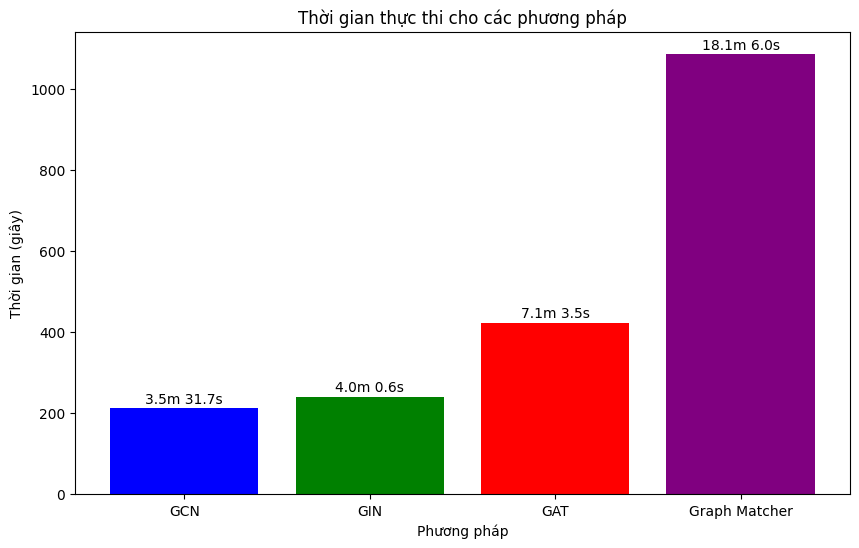

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu thời gian (phút và giây)
methods = ['GCN', 'GIN', 'GAT', 'Graph Matcher']
times_minutes = [3, 4, 7, 18]
times_seconds = [31.7, 0.6, 3.5, 6.0]

# Chuyển đổi thời gian sang giây để vẽ biểu đồ
total_seconds = [m * 60 + s for m, s in zip(times_minutes, times_seconds)]

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, total_seconds, color=['blue', 'green', 'red', 'purple'])

# Thêm nhãn cho các cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, f'{yval/60:.1f}m {yval%60:.1f}s', ha='center', va='bottom')

# Thêm tiêu đề và nhãn trục
plt.title('Thời gian thực thi cho các phương pháp')
plt.xlabel('Phương pháp')
plt.ylabel('Thời gian (giây)')

# Hiển thị biểu đồ
plt.show()
